&#x1f12f; Javier Bejar - APA/GEI/FIB/UPC (2022)

In [1]:
# Uncomment to upgrade packages
!pip install pandas --user --upgrade --quiet
!pip install numpy==1.23.5 --user --upgrade --quiet
!pip install scipy --user --upgrade --quiet
!pip install statsmodels --user --upgrade --quiet
!pip install seaborn --user --upgrade --quiet
!pip install matplotlib --user --upgrade --quiet
!pip install scikit-learn --user --upgrade 
!pip install imblearn --upgrade --user --quiet
!pip install scikit-optimize --user --quiet
!pip install dtreeviz==1.4.1 --user --upgrade  --quiet
!pip install yellowbrick --upgrade --user --quiet
!pip install apafib --upgrade --user --quiet
!pip install eli5 --upgrade --user --quiet

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

# APA - Laboratorio - Sesión 7
## Árboles de decisión - Ensembles

In [3]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                     f1_score, make_scorer, accuracy_score, roc_auc_score

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.ensemble import StackingClassifier, VotingClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from skopt import BayesSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

import eli5
from dtreeviz.trees import dtreeviz

import warnings
from apafib import load_attrition

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [4]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'test f1 score (0)'] = f1_score(y_test, clf.predict(X_test), pos_label=0)
    df.loc[nclf,'test f1 score (1)'] = f1_score(y_test, clf.predict(X_test), pos_label=1)
    df.loc[nclf,'test f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    return df

results_df = pd.DataFrame()

# Sección 1: Employee Attrition for Healthcare

Entre las muchas aplicaciones prácticas de aprendizaje, una de ellas es la predicción de si alguien tomará cierta decisión dada su historia, por ejemplo si alguien va a dejar de ser cliente o va a dejar su trabajo, es lo que se conoce como tasa de abandono (en inglés churn rate o attrition rate).

Este es un conjunto de datos ficticio de personal de salud creado por IBM como demostración que usaremos para probar modelos de árboles de decisión y combinación de clasificadores (https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset).

El elemento diferente que tiene este tipo de aplicación es que habitualmente hay un desequilibrio entre las clases ya que a no ser que pase algo raro, la gente no deja una compañia en masa.

Cargaremos los datos y haremos alguna visualización

In [5]:
data = load_attrition()

In [6]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [7]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1470.0,NaN,NaN,NaN,36.924,9.135,18.0,30.0,36.0,43.0,60.0
Attrition,1470,2,No,1233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessTravel,1470,3,Travel_Rarely,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DailyRate,1470.0,NaN,NaN,NaN,802.486,403.509,102.0,465.0,802.0,1157.0,1499.0
Department,1470,3,Research & Development,961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistanceFromHome,1470.0,NaN,NaN,NaN,9.193,8.107,1.0,2.0,7.0,14.0,29.0
Education,1470.0,NaN,NaN,NaN,2.913,1.024,1.0,2.0,3.0,4.0,5.0
EducationField,1470,6,Life Sciences,606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeCount,1470.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
EmployeeNumber,1470.0,NaN,NaN,NaN,1024.865,602.024,1.0,491.25,1020.5,1555.75,2068.0


Nuestro problema es binario, podemos ver que hay un gran desbalance entre las clases ~ 1:6

In [8]:
cls = [str(v) for v in sorted(data['Attrition'].unique())]
data['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

## Preproceso

Como trabajaremos con árboles de decisión transformaremos todos los atributos a valores numéricos. Eliminaremos también la variable `Over18`, `StandardHours` y `EmployeeCount` ya que todos sus valores son el mismo y `EmployeeId` que es identificador. Este conjunto de datos no tiene valores perdidos.

In [9]:
data.drop(columns=['Over18', 'EmployeeCount', 'StandardHours', 'EmployeeNumber'],  inplace=True)

In [10]:
for c in data.columns:
    if data[c].dtype.kind == 'O':
        data[c] = data[c].astype('category').cat.codes

Ahora podemos dividir nuestros datos en entrenamiento y test. No hace falta normalización ya que trabajaremos con árboles de decisión, en este modelo no importa el rango de las variables, además si no las transformamos podremos interpretar directamente el árbol.

In [11]:
X= data.loc[:,data.columns!='Attrition']
y= data.loc[:,'Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

Podemos visualizar las variables

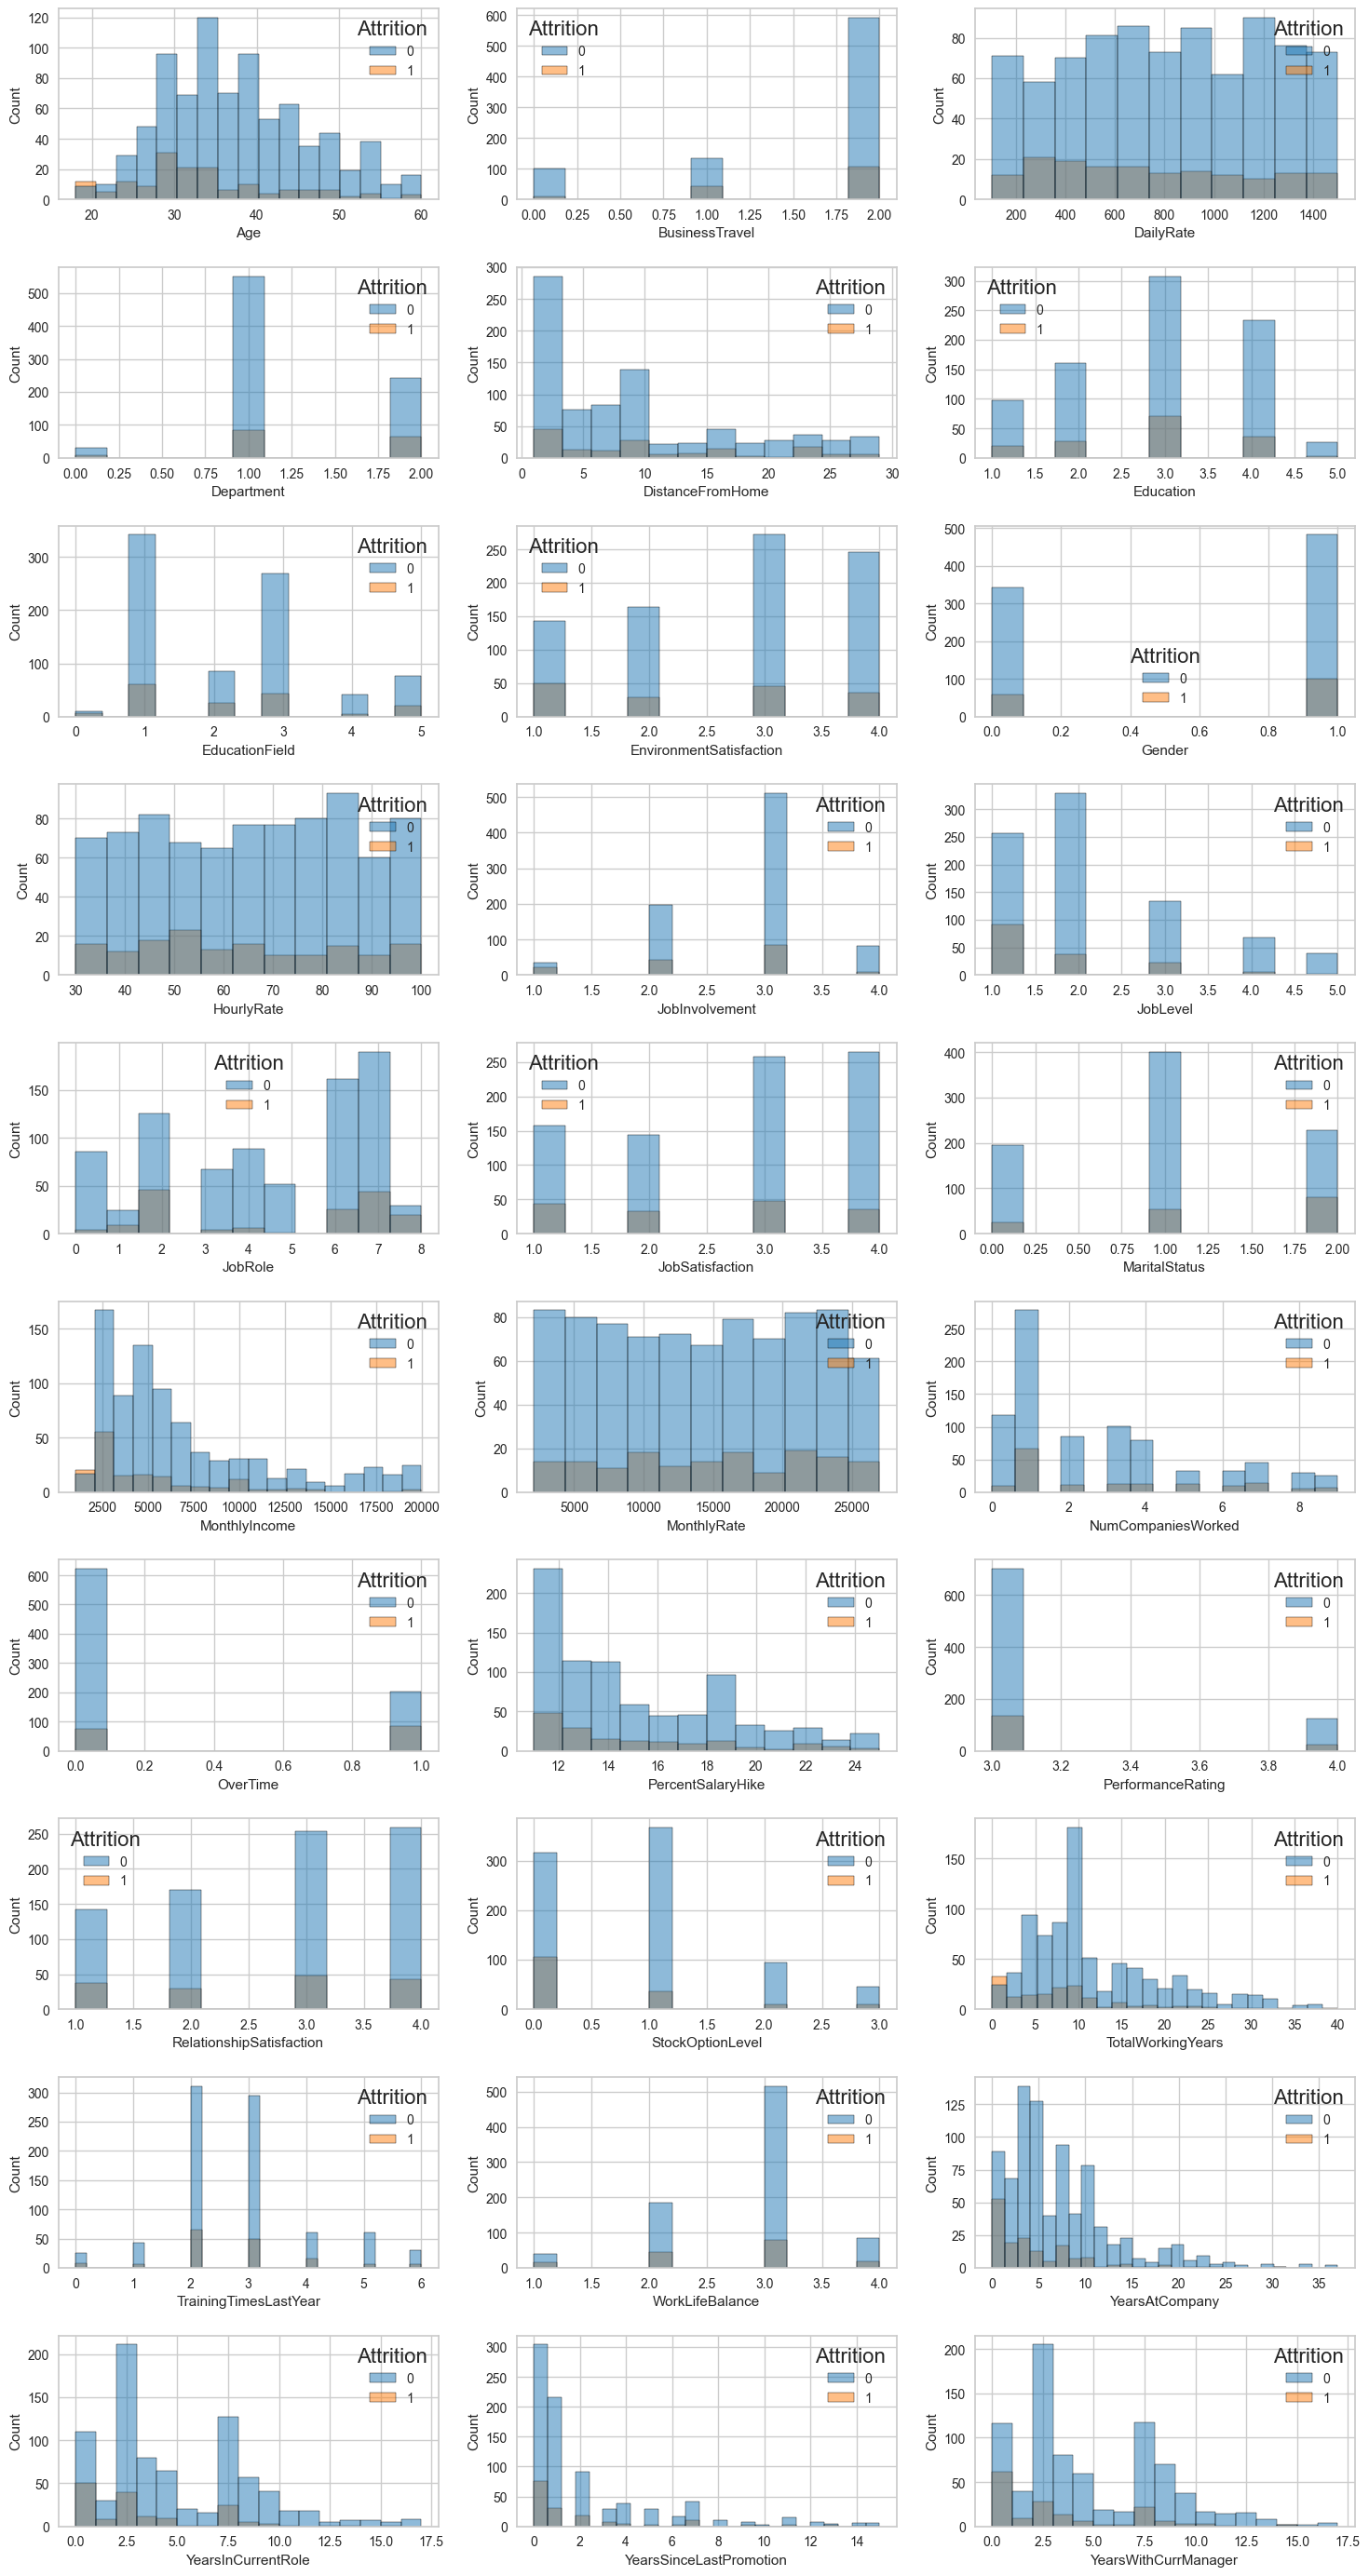

In [12]:
fig, axes = plt.subplots(10,3,figsize=(15,28))

X_train_frame = pd.DataFrame(X_train)
X_train_frame.columns=X.columns
for i, c in enumerate(X.columns):
    ax = axes.reshape(-1)[i]
    b = sns.histplot(x=c,data=X_train_frame,ax=ax, hue=y_train, palette='tab10')
plt.tight_layout()

Podemos visualizar los datos con PCA aunque los datos no son gausianos, la mayoria son atributos discretos y los que son continuos no siguen esa distribución en su mayoría (excepto Age)

In [13]:
pca = PCA().fit(X_train);

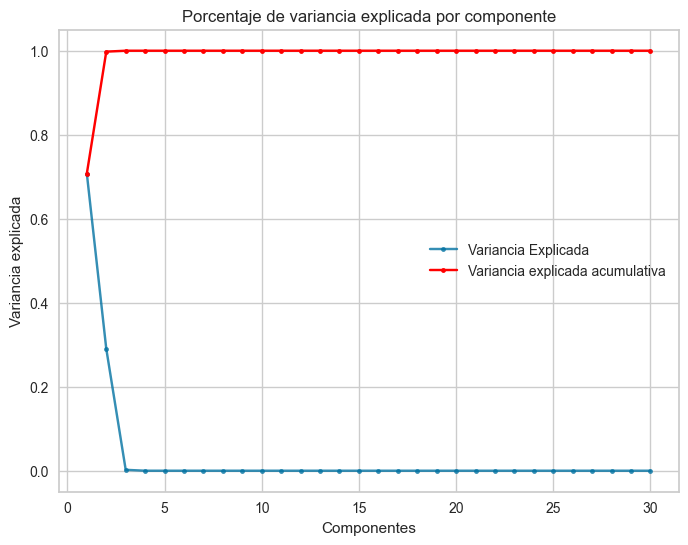

In [14]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Parece que dos componentes se llevan prácticamente el 100% de la variancia, aunque en la visualización de estos dos componentes podemos ver que no hay mucha separación entre las clases.

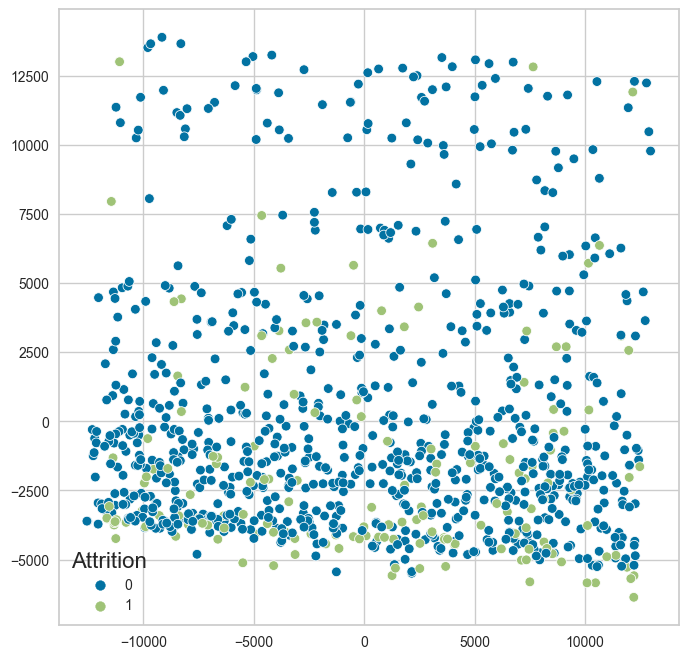

In [15]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train);

Nota:

Estas dos variables controlan el número de particiones de validación cruzada que se usan en el ajuste de los modelos y el número de modelos que prueba la búsqueda bayesiana, por defecto se usa 5 y 40. Aparte de esto, la aleatoriedad que interviene en los modelos cambiará los resultados finales.

In [16]:
cv=10
iter=40

plt.rcParams.update({'font.size': 16})

### Árboles de decisión

Empezaremos ajustando un árbol de decisión a los datos explorando los diferentes hiper parámetros del modelo

In [17]:
param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt =  DecisionTreeClassifier(random_state=0)
dt_bs =  BayesSearchCV(dt,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
dt_bs.fit(X_train, y_train);

In [18]:
show_html(pd.DataFrame(dt_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
32,"{'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 5, 'min_samples_leaf': 5, 'splitter': 'best'}",0.857,1
25,"{'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'splitter': 'best'}",0.857,1
24,"{'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'splitter': 'best'}",0.857,1
17,"{'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_leaf': 2, 'splitter': 'best'}",0.857,1
31,"{'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 5, 'min_samples_leaf': 3, 'splitter': 'best'}",0.857,1


In [19]:
print(classification_report(dt_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(dt_bs, X_test, y_test, 'DTree base', results_df)

              precision    recall  f1-score   support

          No       0.97      0.86      0.91       458
         Yes       0.21      0.57      0.30        28

    accuracy                           0.85       486
   macro avg       0.59      0.72      0.61       486
weighted avg       0.93      0.85      0.88       486



Podemos ver que lo hacemos muy bien en la clase negativa a costa de hacerlo muy mal en la clase positiva, dado que precisamente tenemos más interes en su predicción no es un modelo demasiado bueno.

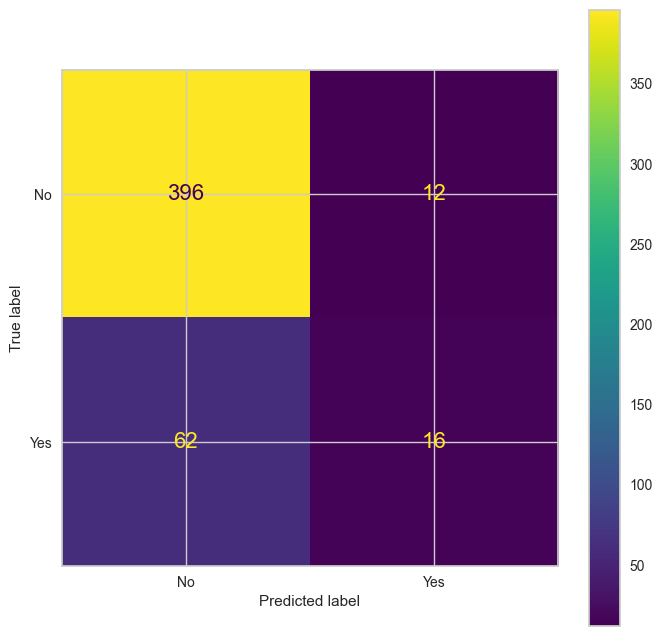

In [20]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_bs, X_test,y_test, display_labels=cls, ax=plt.subplot());

En la curva ROC podemos ver que si cambiaramos el punto de decisión podríamos llegar a algo más de un 60% de verdaderos positivos con un numero de falsos positivos de alrededor del 25%. Esto supondía alrededor de 100 ejemplos de la clase negativa clasificados como clase positiva, habría que ver si tiene sentido en el problema y el coste que supone equivocarse.

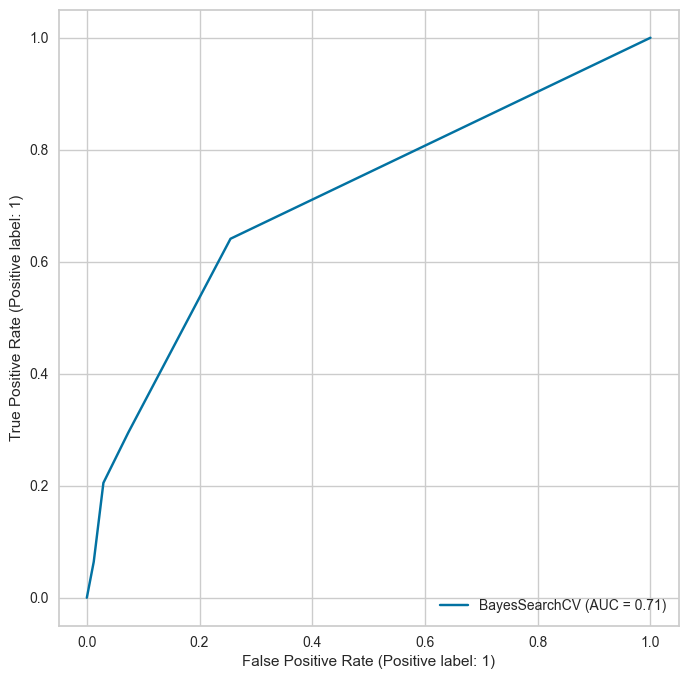

In [21]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(dt_bs, X_test,y_test, pos_label=1, ax=plt.subplot());

Podemos visualizar el árbol resultante, pero hemos de tener en cuenta que cambios en como seleccionamos el conjunto de entrenamiento cambiarán bastante las decisiones del árbol. Podemos ver que es bastante sencillo.

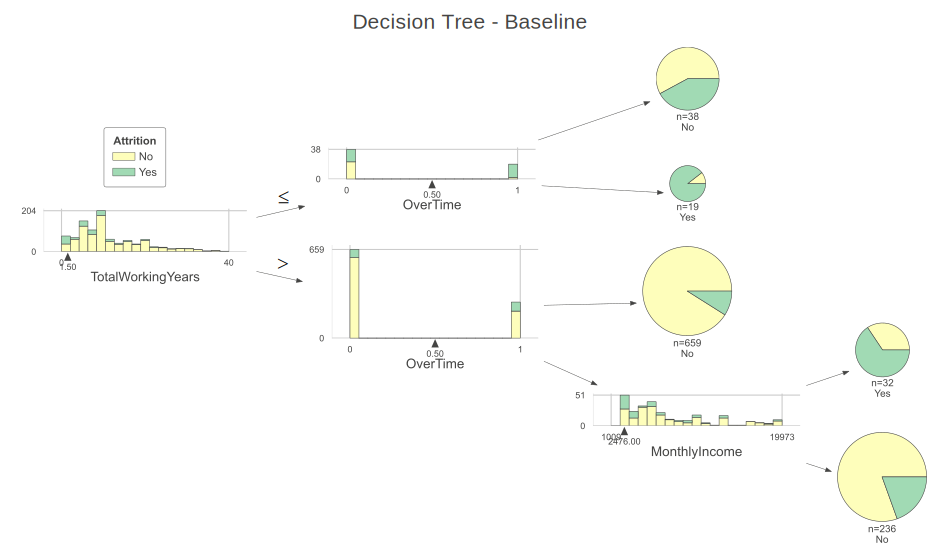

In [22]:
dtreeviz(dt_bs.best_estimator_, scale=1.5,
               x_data=X_train,
               y_data=y_train,
               target_name='Attrition',
               feature_names=[c for c in data.columns if c!='Attrition'],
               class_names=cls,
               title="Decision Tree - Baseline",
               orientation='LR')

Existen diferentes cosas que podemos hacer para incrementar la precisión y recuperación del modelos.

- Asignar diferente peso a cada una de las clases de manera que intente reducir el error de la que nos interesa
- Remuestrear las clases de manera que tengamos un conjunto de entrenamiento con más balance entre clases aumentando la clase minoritara o disminuyendo la mayoritaria

# Peso de las clases

El modelo de árbol de decisión (y también otros modelos) permite balancear las clases a partir de su probabilidad en el conjunto de datos, de manera que podamos asignarles un peso diferente. Podemos poner la relación de pesos que queramos, dependiendo de este valor podemos tener resultados en los que la clase minoritaria mejora su clasificación.

Hay que tener cuidado con este peso ya que no garantiza que el clasificador lo haga bien aunque aumentemos mucho el peso de la clase minoritaria (el valor que hay esta puesto _mágicamente_)

In [23]:
param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt =  DecisionTreeClassifier(random_state=0, class_weight={0:1,1:5.5})
dt_cw_bs =  BayesSearchCV(dt,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
dt_cw_bs.fit(X_train, y_train);

In [24]:
show_html(pd.DataFrame(dt_cw_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
23,"{'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 30, 'min_samples_leaf': 2, 'splitter': 'best'}",0.758,1
24,"{'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 30, 'min_samples_leaf': 5, 'splitter': 'best'}",0.757,2
14,"{'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'splitter': 'best'}",0.736,3
4,"{'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'splitter': 'best'}",0.736,3
11,"{'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 30, 'min_samples_leaf': 2, 'splitter': 'best'}",0.736,3


El cambiar los pesos ha reducido el acierto global del modelo ya que hemos empezado a predecir mejor la clase que nos importa más. En este caso acertamos bastantes más  ejemplos de esa clase, pero con un gran número de falsos positivos. En algunas aplicaciones esto puede ser un problema. También habría que sopesar si la caida en acierto nos compensa.

In [25]:
print(classification_report(dt_cw_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(dt_cw_bs, X_test, y_test, 'DTree class weights', results_df)

              precision    recall  f1-score   support

          No       0.85      0.88      0.86       393
         Yes       0.38      0.32      0.35        93

    accuracy                           0.77       486
   macro avg       0.62      0.60      0.61       486
weighted avg       0.76      0.77      0.76       486



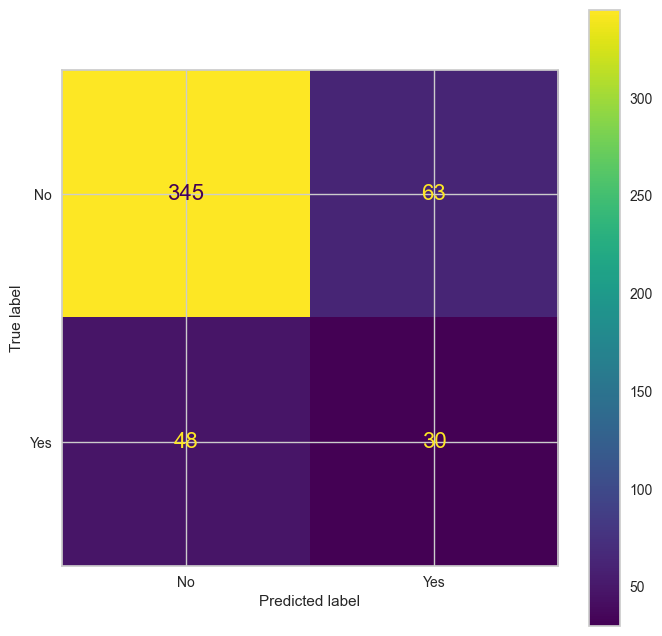

In [26]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_cw_bs, X_test,y_test, display_labels=cls, ax=plt.subplot());

El AUC no ha mejorado en este caso, pero puede depender de la muestra concreta con la que entrenemos el árbol, este es un problema que aparecerá en cualquier modelo que hagamos con un solo árbol.

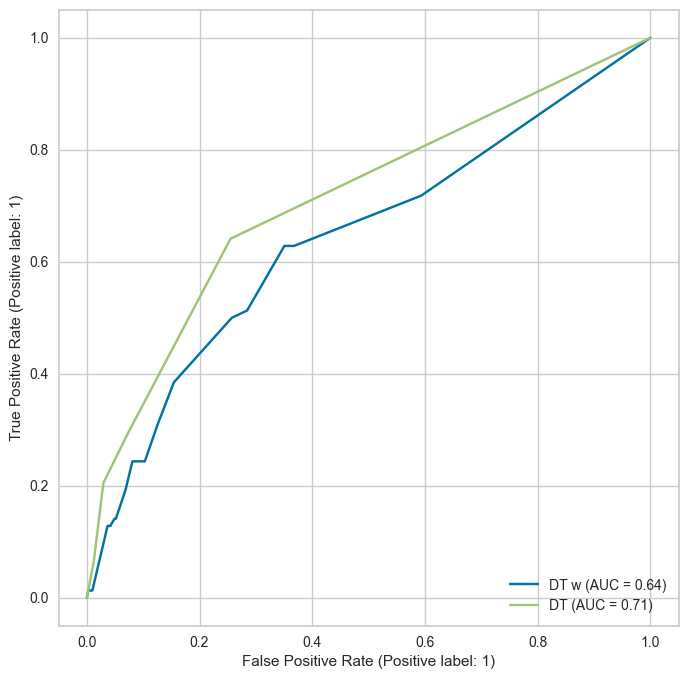

In [27]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(dt_cw_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="DT w");
RocCurveDisplay.from_estimator(dt_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="DT");

Podemos ver que el árbol se ha vuelto mucho más complejo para poder distinguir ese número extra de ejemplos de la clase positiva. Tampoco coindide en como este árbol toma decisiones.

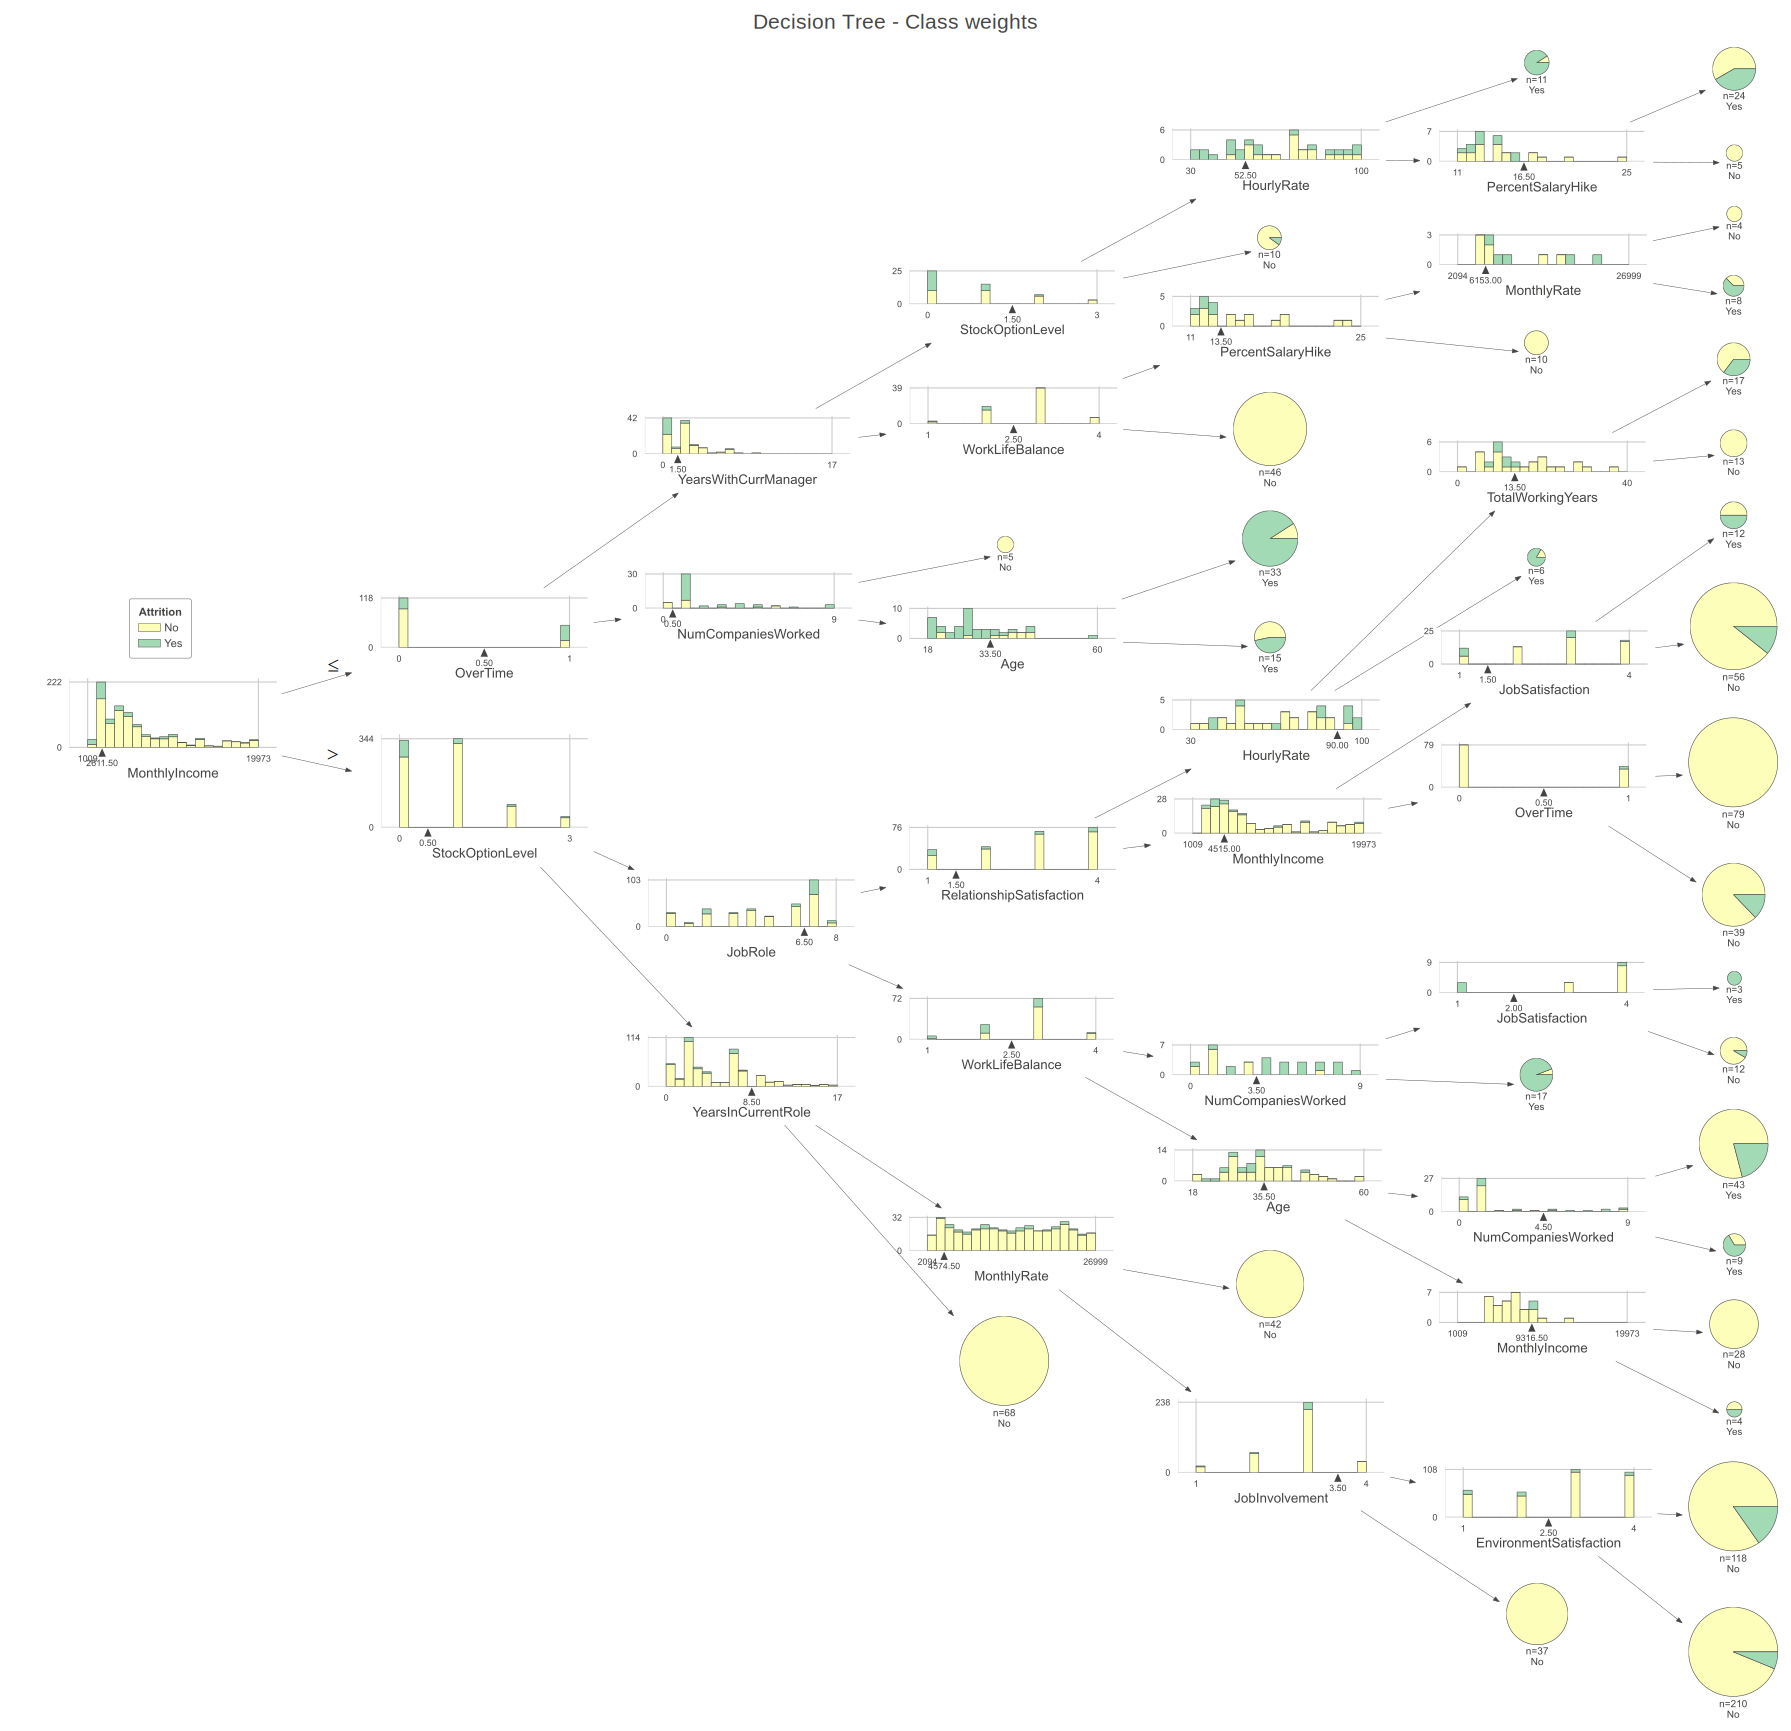

In [28]:
dtreeviz(dt_cw_bs.best_estimator_, scale=1.5,
               x_data=X_train,
               y_data=y_train,
               target_name='Attrition',
               feature_names=[c for c in data.columns if c!='Attrition'],
               class_names=cls,
               title="Decision Tree - Class weights",
               orientation='LR')

### Submuestreo de la clase mayoritaria

La libreria imblearn tiene diferentes algoritmos para el tratamiento de palabras con desbalance de clases.

Empezaremos por un método que reduce la muestra de la clase mayoritaria para que la relación que hay entre las dos sea un valor dado. Aprovecharemos que podemos juntar diferentes pasos en `Pipelines` para añadir todo el proceso al ajuste de hiperparámetros.

La posibilidad de hacer `Pipelines` la tiene también scikit-learn, pero las funciones de imblearn tienen una signatura diferente y hace falta usar el objeto específico de esta librería para que funcione.

In [29]:
param = {'dt__criterion':['gini', 'entropy'], 
         'dt__max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'dt__min_samples_leaf':[1,2,3,5,10], 
         'dt__splitter': ['best', 'random'], 
         'dt__max_leaf_nodes':[5, 10, 20, 30],
         'rus__sampling_strategy':np.linspace(0.2,0.5,16)}

dt =  DecisionTreeClassifier(random_state=0)
rus = RandomUnderSampler(random_state=0)
dt_us= Pipeline([('rus', rus), ('dt', dt)])
dt_us_bs =  BayesSearchCV(dt_us,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
dt_us_bs.fit(X_train, y_train);

In [30]:
show_html(pd.DataFrame(dt_us_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
36,"{'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 20, 'dt__min_samples_leaf': 10, 'dt__splitter': 'best', 'rus__sampling_strategy': 0.22}",0.859,1
37,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 20, 'dt__min_samples_leaf': 2, 'dt__splitter': 'best', 'rus__sampling_strategy': 0.22}",0.858,2
34,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 30, 'dt__min_samples_leaf': 1, 'dt__splitter': 'best', 'rus__sampling_strategy': 0.22}",0.858,2
32,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 3, 'dt__splitter': 'best', 'rus__sampling_strategy': 0.22}",0.858,2
26,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 20, 'dt__min_samples_leaf': 10, 'dt__splitter': 'best', 'rus__sampling_strategy': 0.22}",0.857,5


Podemos ver que con esta estrategia hemos ganado algo respecto al árbol original, perdiendo un poco en el acierto global en el test, pero mejorando  en la clase que nos interesa.

In [31]:
print(classification_report(dt_us_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(dt_us_bs, X_test, y_test, 'DTree under samp', results_df)

              precision    recall  f1-score   support

          No       0.94      0.87      0.91       441
         Yes       0.28      0.49      0.36        45

    accuracy                           0.84       486
   macro avg       0.61      0.68      0.63       486
weighted avg       0.88      0.84      0.86       486



Como consecuencia aumentamos los que acertamos en la clase positiva, pero también aumentanlos falsos negativos.

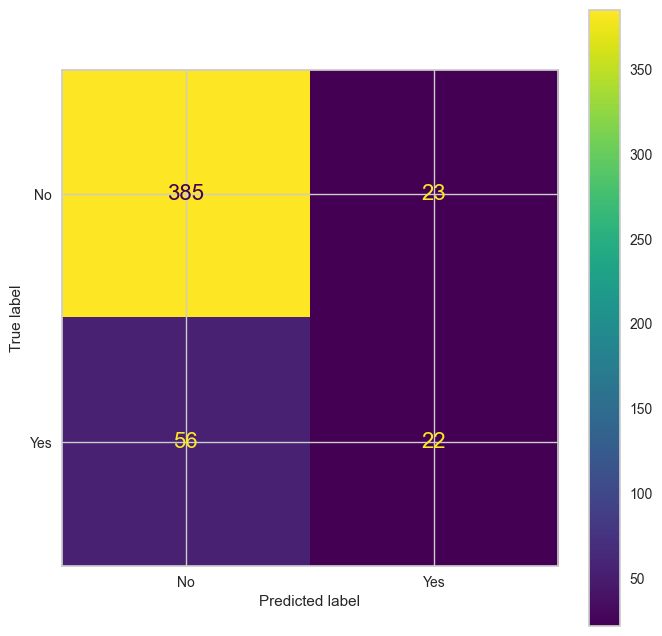

In [32]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_us_bs, X_test,y_test, display_labels=cls, ax=plt.subplot());

La curva ROC es muy parecida a la del modelo incial, se ha reducido algo AUC, tenemos basicamente los mismos puntos de corte.

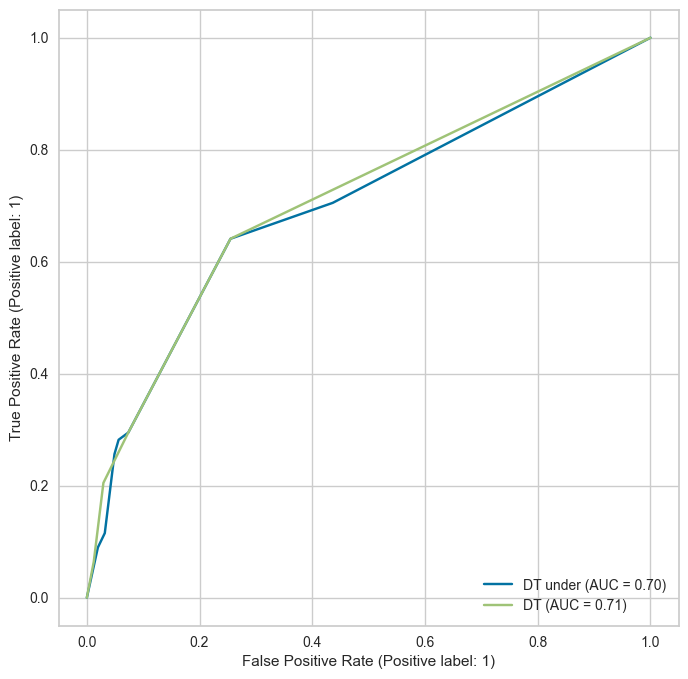

In [33]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(dt_us_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="DT under");
RocCurveDisplay.from_estimator(dt_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="DT");

El árbol esta en un punto intermedio de complejidad.

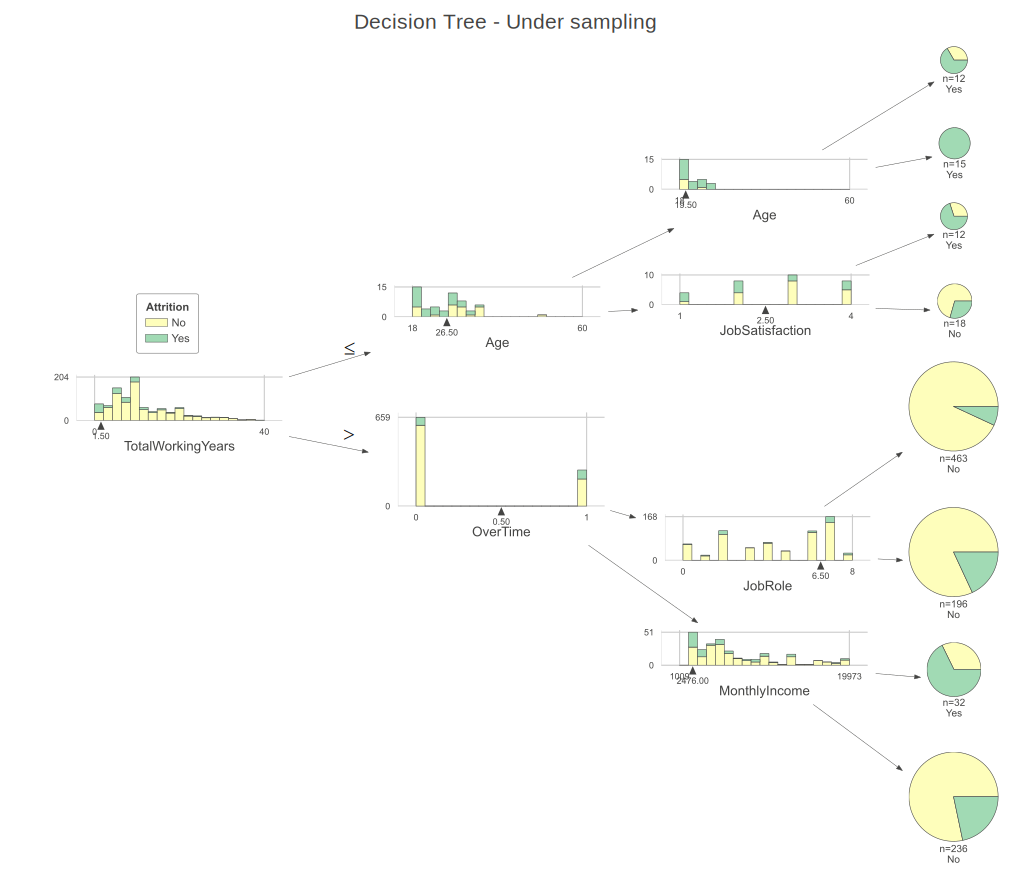

In [34]:
dtreeviz(dt_us_bs.best_estimator_['dt'], scale=1.5,
               x_data=X_train,
               y_data=y_train,
               target_name='Attrition',
               feature_names=[c for c in data.columns if c!='Attrition'],
               class_names=cls,
               title="Decision Tree - Under sampling",
               orientation='LR')


### Super muesteo de la clase minoritaria

En este caso se añaden muestras repetidas de la clase minoritaria. 

In [35]:
param = {'dt__criterion':['gini', 'entropy'], 
         'dt__max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'dt__min_samples_leaf':[1,2,3,5,10], 
         'dt__splitter': ['best', 'random'], 
         'dt__max_leaf_nodes':[5, 10, 20, 30],
         'ros__sampling_strategy':np.linspace(0.2,0.5,16)}

dt =  DecisionTreeClassifier(random_state=0)
ros = RandomOverSampler(random_state=0)
dt_os= Pipeline([('ros', ros), ('dt', dt)])
dt_os_bs =  BayesSearchCV(dt_os,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
dt_os_bs.fit(X_train, y_train);

In [36]:
show_html(pd.DataFrame(dt_os_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
35,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 5, 'dt__splitter': 'best', 'ros__sampling_strategy': 0.30000000000000004}",0.857,1
29,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 30, 'dt__min_samples_leaf': 1, 'dt__splitter': 'best', 'ros__sampling_strategy': 0.30000000000000004}",0.856,2
16,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 5, 'dt__min_samples_leaf': 1, 'dt__splitter': 'best', 'ros__sampling_strategy': 0.24000000000000002}",0.854,3
39,"{'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 20, 'dt__min_samples_leaf': 5, 'dt__splitter': 'best', 'ros__sampling_strategy': 0.32}",0.854,4
17,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 5, 'dt__min_samples_leaf': 1, 'dt__splitter': 'best', 'ros__sampling_strategy': 0.22}",0.852,5


Nos sale un modelo exactamente igual que el original, no parece que replicar instancias haya ayudado al modelo. Por los resultados de la exploración el oversampling que da mejores resultados deja practicamente el tamaño de la clase positiva como está.

In [37]:
print(classification_report(dt_os_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(dt_os_bs, X_test, y_test, 'DTree over samp', results_df)

              precision    recall  f1-score   support

          No       0.93      0.87      0.90       440
         Yes       0.24      0.41      0.31        46

    accuracy                           0.82       486
   macro avg       0.59      0.64      0.60       486
weighted avg       0.87      0.82      0.84       486



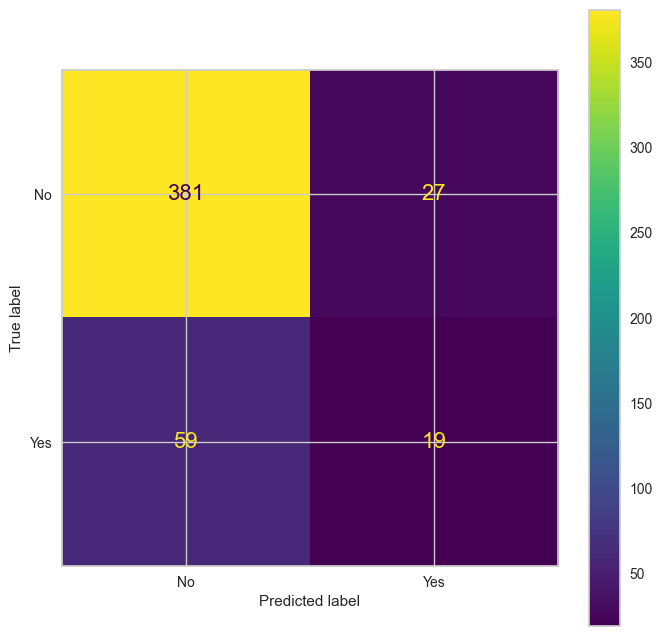

In [38]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_os_bs, X_test,y_test, display_labels=cls, ax=plt.subplot());

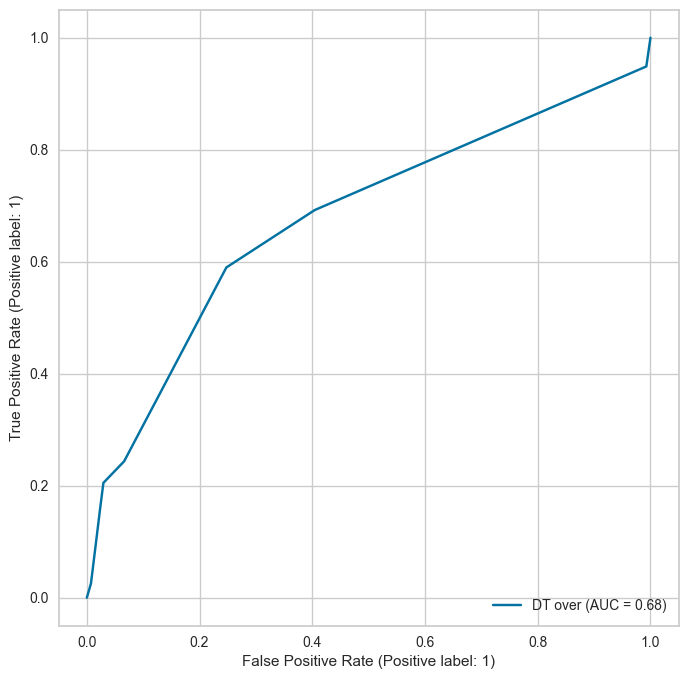

In [39]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(dt_os_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='DT over');

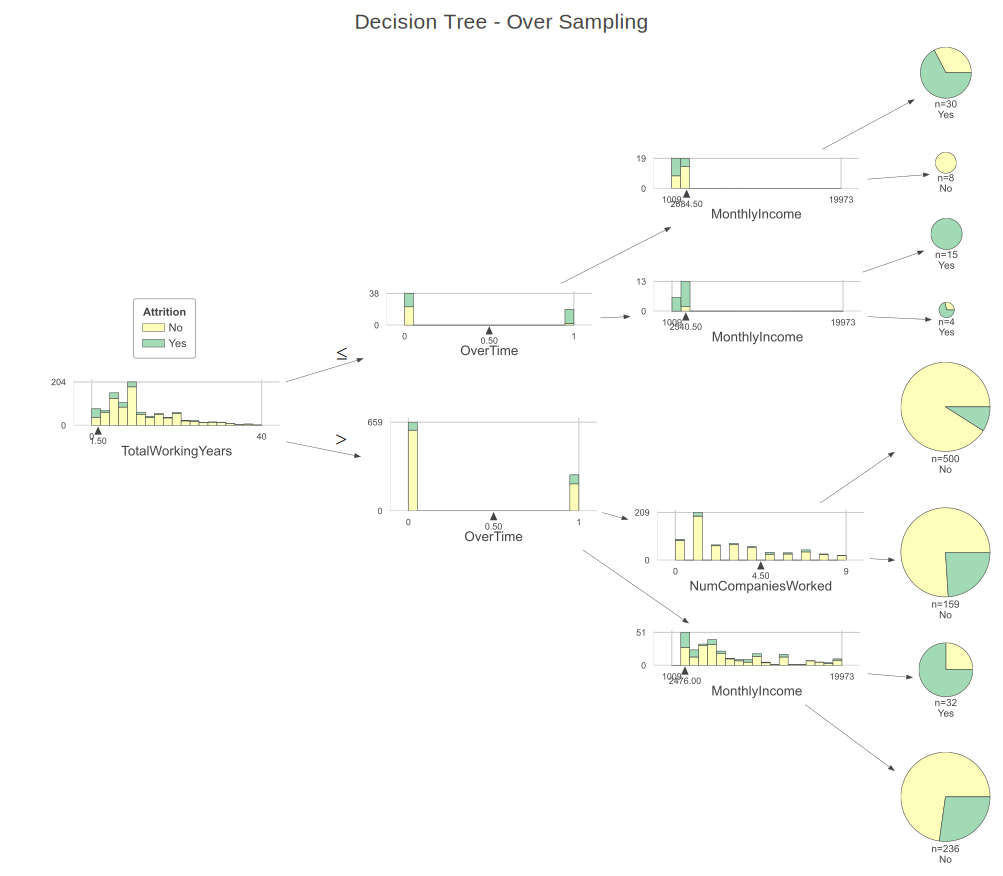

In [40]:
dtreeviz(dt_os_bs.best_estimator_['dt'], scale=1.5,
               x_data=X_train,
               y_data=y_train,
               target_name='Attrition',
               feature_names=[c for c in data.columns if c!='Attrition'],
               class_names=cls,
               title="Decision Tree - Over Sampling",
               orientation='LR')


### Super muestreo de la clase mayoritaria con SMOTE

SMOTE es un algoritmo de super muestreo que en lugar de repetir ejemplos ya existentes genera ejemplos nuevos perturbando los ya existentes asumiendo que estos ejemplos pertenecerán a la misma clase

In [41]:
param = {'dt__criterion':['gini', 'entropy'], 
         'dt__max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'dt__min_samples_leaf':[1,2,3,5,10], 
         'dt__splitter': ['best', 'random'], 
         'dt__max_leaf_nodes':[5, 10, 20, 30],
          'smote__sampling_strategy':np.linspace(.2,0.5,16)}

dt =  DecisionTreeClassifier(random_state=0)
smt = SMOTE(random_state=0)
dt_sm= Pipeline([('smote', smt), ('dt', dt)])
dt_sm_bs =  BayesSearchCV(dt_sm,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
dt_sm_bs.fit(X_train, y_train);

In [42]:
show_html(pd.DataFrame(dt_sm_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
22,"{'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 20, 'dt__min_samples_leaf': 3, 'dt__splitter': 'random', 'smote__sampling_strategy': 0.30000000000000004}",0.854,1
35,"{'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 3, 'dt__splitter': 'random', 'smote__sampling_strategy': 0.28}",0.853,2
17,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 20, 'dt__min_samples_leaf': 2, 'dt__splitter': 'random', 'smote__sampling_strategy': 0.30000000000000004}",0.852,3
18,"{'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 20, 'dt__min_samples_leaf': 3, 'dt__splitter': 'random', 'smote__sampling_strategy': 0.30000000000000004}",0.852,3
36,"{'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 10, 'dt__splitter': 'random', 'smote__sampling_strategy': 0.30000000000000004}",0.852,5


Los resultados de este método no son mejores, incluso han empeorado  el resultado en la clase que nos interesa

In [43]:
print(classification_report(dt_sm_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(dt_sm_bs, X_test, y_test, 'DTree SMOTE', results_df)

              precision    recall  f1-score   support

          No       0.98      0.84      0.90       472
         Yes       0.05      0.29      0.09        14

    accuracy                           0.83       486
   macro avg       0.51      0.56      0.50       486
weighted avg       0.95      0.83      0.88       486



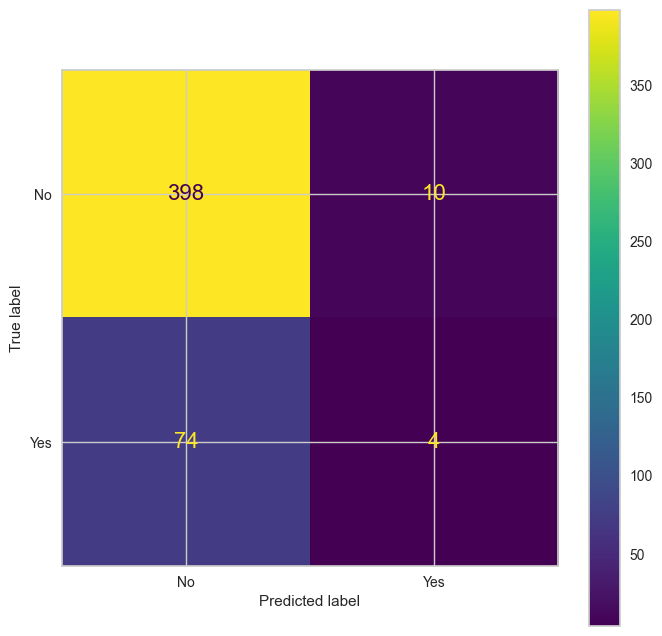

In [44]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_sm_bs, X_test,y_test, display_labels=cls, ax=plt.subplot());

Podemos ver que la AUC es también peor

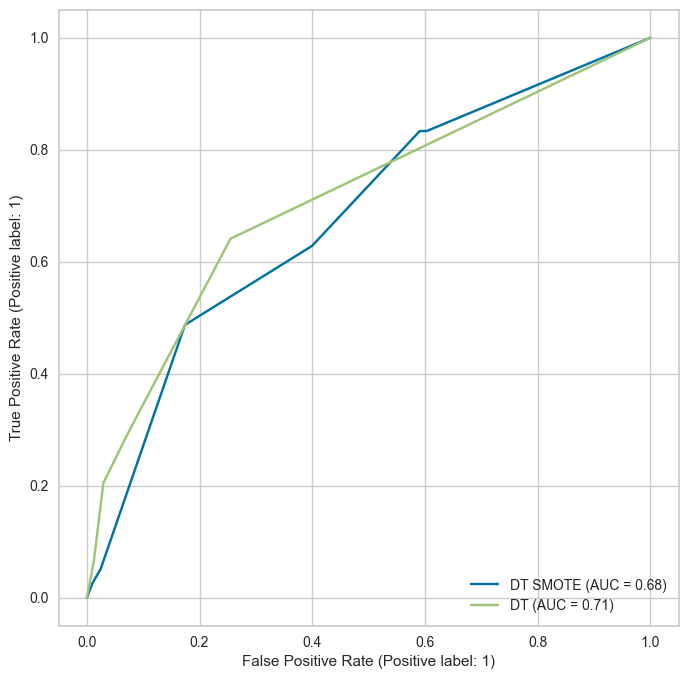

In [45]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(dt_sm_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="DT SMOTE");
RocCurveDisplay.from_estimator(dt_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="DT");

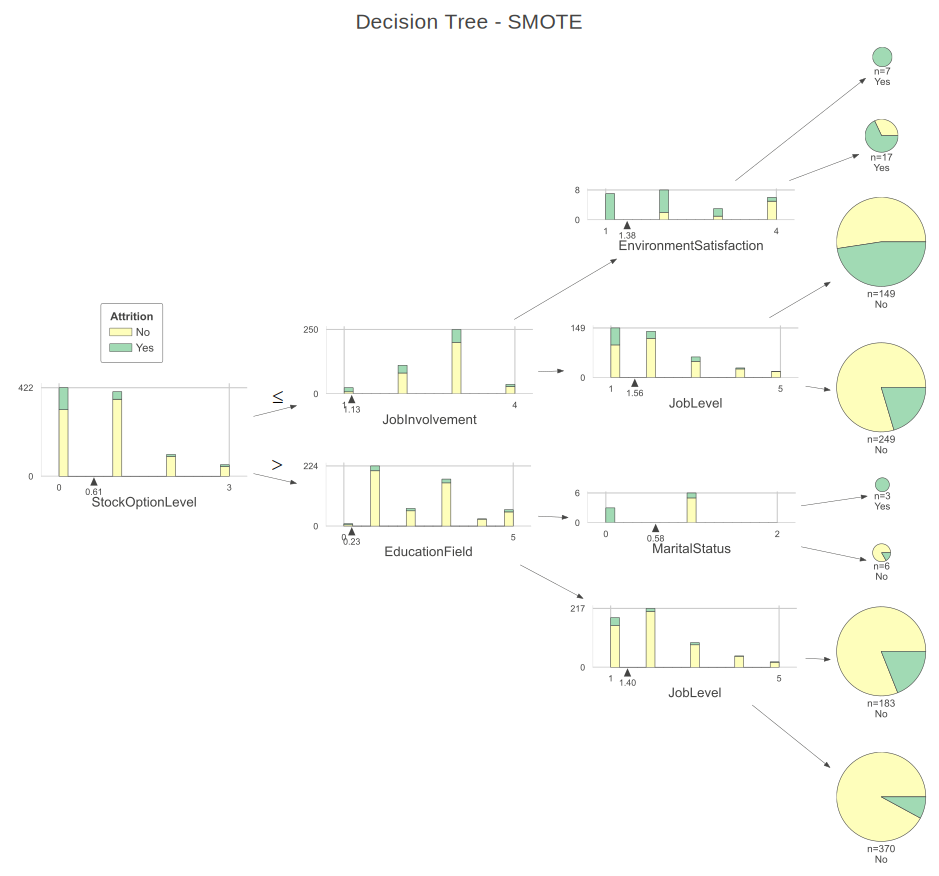

In [46]:
dtreeviz(dt_sm_bs.best_estimator_['dt'], scale=1.5,
               x_data=X_train,
               y_data=y_train,
               target_name='Attrition',
               feature_names=[c for c in data.columns if c!='Attrition'],
               class_names=cls,
               title="Decision Tree - SMOTE",
               orientation='LR')


## Combinación de clasificadores basadas en árboles de decisióm

### Random Forest

Una ventaja de utilizar combinación de clasificadores basados en árboles es que cada uno de los árboles ve el conjunto de datos de una manera diferente ya sea porque se muestrean los atributos o los ejemplos, eso puede ayudar a corregir un problema de desbalance en los datos.

Comenzaremos con random forest que combina árboles donde cada uno selecciona una muestra con reposición del conjunto de datos, asi que en nuestro caso el desbalance en cada árbol será diferente.

In [47]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rf =  RandomForestClassifier(random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train, y_train);

In [48]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
20,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 25}",0.867,1
17,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 25}",0.866,2
15,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}",0.864,3
5,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 40}",0.863,4
18,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 40}",0.862,5


En este caso estamos obteniendo resultados peores en la clase que nos interesa con un acierto global parecido al arbol inicial. Eso si, ahora tenemos muchos más árboles, por lo que el coste de inferencia se ha multiplicado.

In [49]:
print(classification_report(rf_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(rf_bs, X_test, y_test, 'Random Forest', results_df)

              precision    recall  f1-score   support

          No       0.98      0.85      0.91       470
         Yes       0.10      0.50      0.17        16

    accuracy                           0.84       486
   macro avg       0.54      0.68      0.54       486
weighted avg       0.95      0.84      0.89       486



Hemos ganado algo, pero no parece que sea demasiado.

<Figure size 800x800 with 0 Axes>

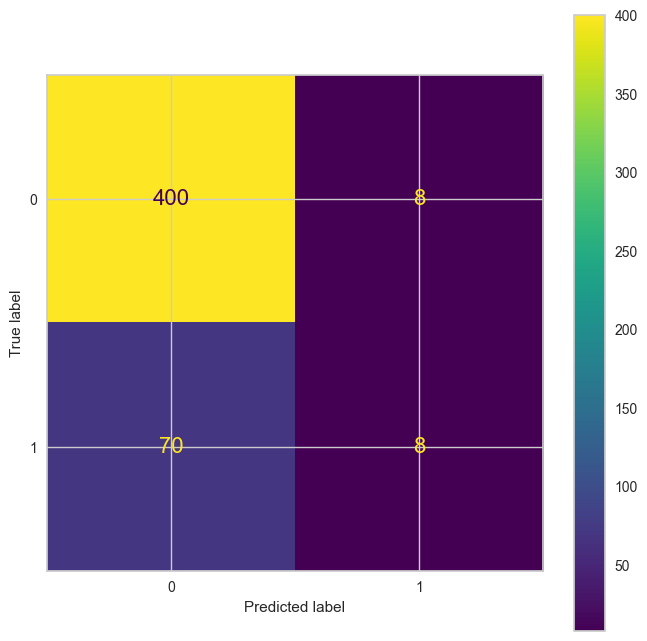

In [50]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rf_bs, X_test,y_test, ax=plt.subplot())

Pero si miramos la curva ROC, podemos ver que la AUC está muy por encima del mejor modelo con un solo árbol de decision, tenemos más puntos de corte donde elegir y ahora el tener 60% de vp nos da un punto de corte por alrededor del 20% de fp, por lo que tenemos un modelo mejor aunque por los resultados del informe de clasificación no lo pareciera.

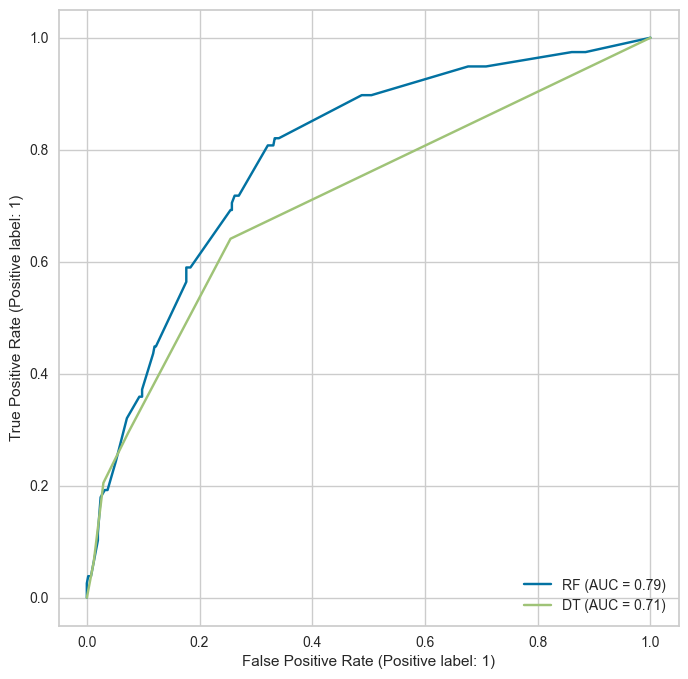

In [51]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(rf_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="RF");
RocCurveDisplay.from_estimator(dt_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="DT");

### Random Forest con peso de las clases 

Dado que el cambiar los pesos de las clases no mejoró el modelo con un árbol podemos ver si pasa lo mismo con la combinación.

In [52]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rf =  RandomForestClassifier(random_state=0, class_weight={0:1,1:5.5})
rf_cw_bs =  BayesSearchCV(rf,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rf_cw_bs.fit(X_train, y_train);

In [53]:
show_html(pd.DataFrame(rf_cw_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
30,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}",0.869,1
11,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 40}",0.868,2
18,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}",0.867,3
34,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}",0.867,4
0,"{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 75}",0.867,5


Podemos ver que efectivamente es el caso, hemos subido el resultado en la clase positiva sin afectar casi a la clase negativa.

In [54]:
print(classification_report(rf_cw_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(rf_cw_bs, X_test, y_test, 'Random Forest CW', results_df)

              precision    recall  f1-score   support

          No       0.97      0.86      0.91       460
         Yes       0.17      0.50      0.25        26

    accuracy                           0.84       486
   macro avg       0.57      0.68      0.58       486
weighted avg       0.93      0.84      0.87       486



<Figure size 800x800 with 0 Axes>

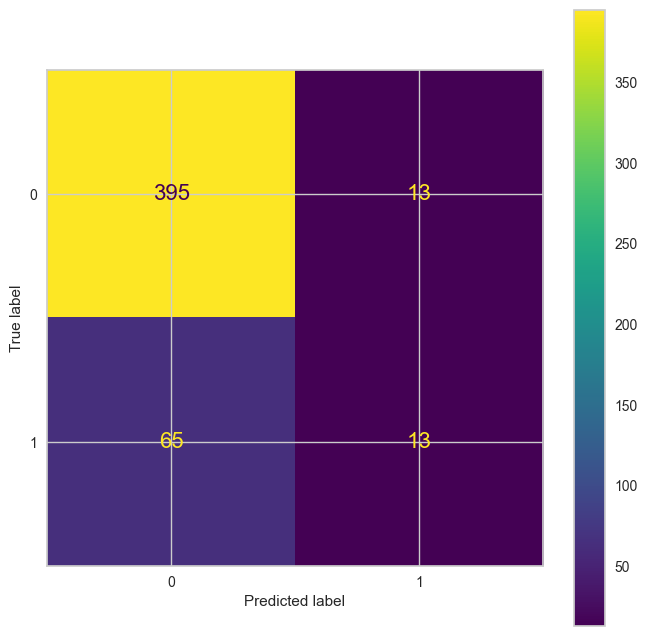

In [55]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rf_cw_bs, X_test,y_test, ax=plt.subplot())

Podemos ver también en la curva ROC que tenemos el corte del 60% de vp por debajo del 20% de fp podemos obtener un porcentaje parecido de vp, en esa parte de la curva es mejor que el modelo anterior aunque tenga un ROC algo peor. 

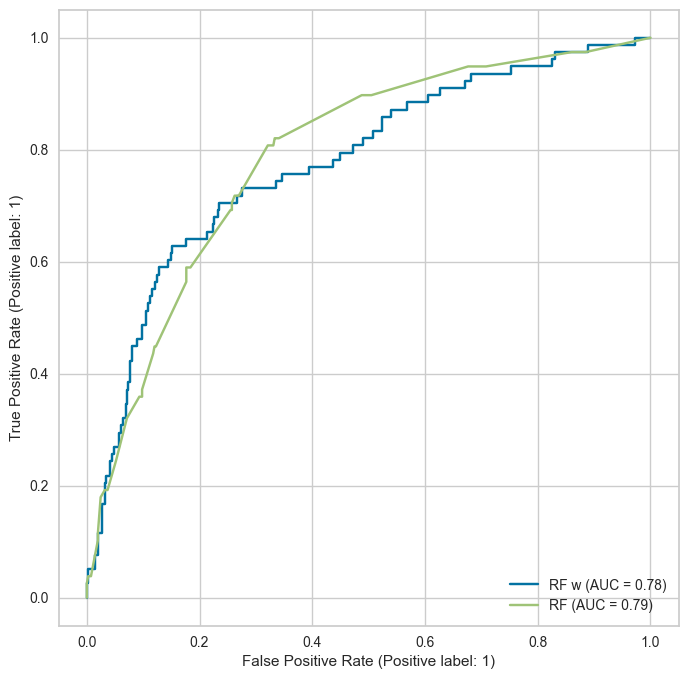

In [56]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(rf_cw_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='RF w');
RocCurveDisplay.from_estimator(rf_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="RF");

### Extremely Randomized Trees

Los Extremely Randomized Trees llevan la randomización un paso más allá generando los árboles prácticamente al azar. Esto nos obligará muchas veces a necesitar más árboles para obtener un resultado equivalente a random forest, pero con la posibilidad de mejores resultados.


In [57]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

et =  ExtraTreesClassifier(random_state=0)
et_bs =  BayesSearchCV(rf,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
et_bs.fit(X_train, y_train);

In [58]:
show_html(pd.DataFrame(et_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
30,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}",0.869,1
11,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 40}",0.868,2
18,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}",0.867,3
34,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}",0.867,4
0,"{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 75}",0.867,5


In [59]:
print(classification_report(et_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(et_bs, X_test, y_test, 'Extra Trees CW', results_df)

              precision    recall  f1-score   support

          No       0.97      0.86      0.91       460
         Yes       0.17      0.50      0.25        26

    accuracy                           0.84       486
   macro avg       0.57      0.68      0.58       486
weighted avg       0.93      0.84      0.87       486



No hemos obtenido un modelo diferente

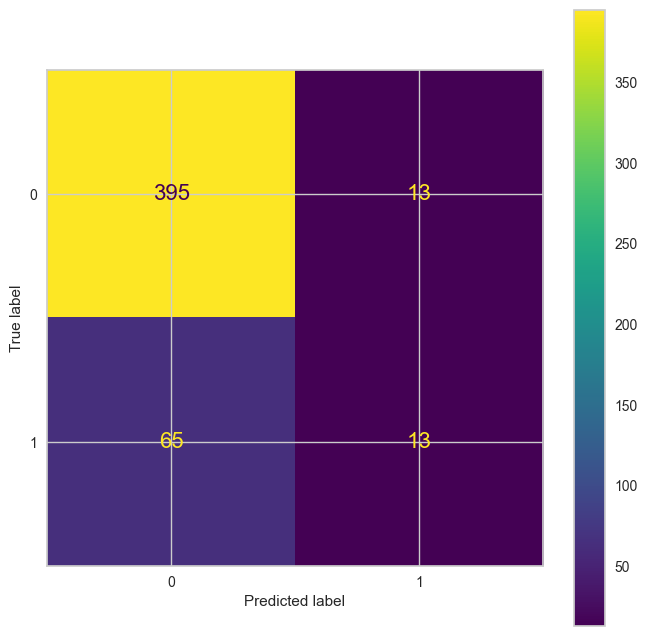

In [60]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(et_bs, X_test,y_test, ax=plt.subplot());

La curva ROC tiene resultados parecidos, pero da mejores puntos de corte al principio de la curva

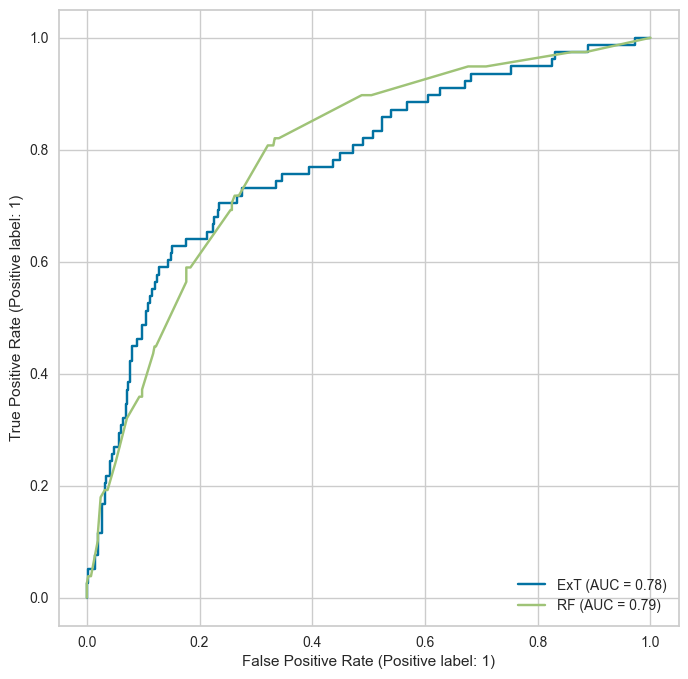

In [61]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(et_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='ExT')
RocCurveDisplay.from_estimator(rf_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="RF");

### Gradient Boosting

Gradient Boosting es un modelo que se construye additivamente, cada modelo se especializa en el residuo del árbol anterior.

La clasificación se resuelve por regresión asumiendo que el clasificador base es probabiliístico y lo que hacermos es hacer regresión sobre esas probabilidades. Dado que el modelo es aditivo, no tiene sentido el manipular los pesos de las clases, esto se hace ya automáticamente, si hay una clase más difícil el siguiente modelo le dará más peso.

In [62]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss', 'exponential'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train, y_train);

In [63]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
36,"{'criterion': 'squared_error', 'learning_rate': 1.0, 'loss': 'exponential', 'max_depth': 1, 'min_samples_leaf': 10, 'n_estimators': 75}",0.871,1
14,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 75}",0.866,2
37,"{'criterion': 'squared_error', 'learning_rate': 1.0, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 40}",0.862,3
33,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.860,4
11,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 75}",0.858,5


El resultado es bueno, aqui dependiendo de la semilla de numeros aleatorios puede estar alrededor del resultado del mejor modelo hasta ahora. 

In [64]:
print(classification_report(gb_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(gb_bs, X_test, y_test, 'Gradient Boosting', results_df)

              precision    recall  f1-score   support

          No       0.95      0.88      0.91       439
         Yes       0.33      0.55      0.42        47

    accuracy                           0.85       486
   macro avg       0.64      0.72      0.66       486
weighted avg       0.89      0.85      0.87       486



<Figure size 800x800 with 0 Axes>

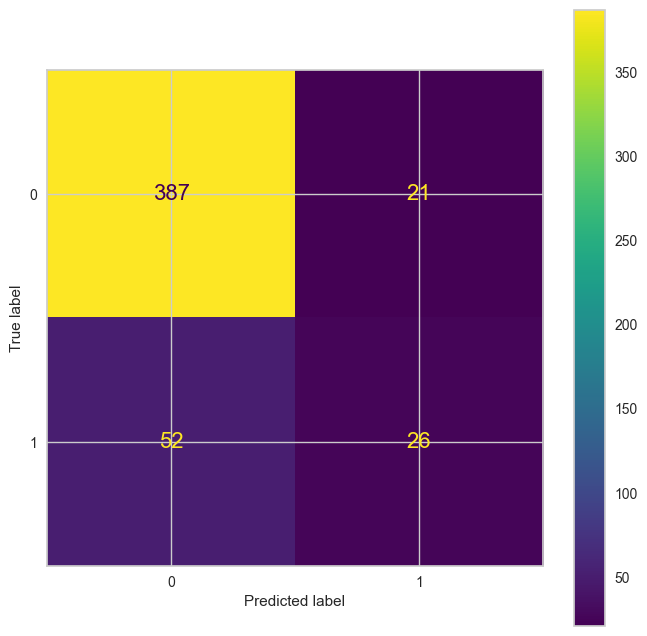

In [65]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gb_bs, X_test,y_test, ax=plt.subplot())

La curva ROC es distinta, aunque esta en línea con los otros modelos los puntos de corte son diferentes

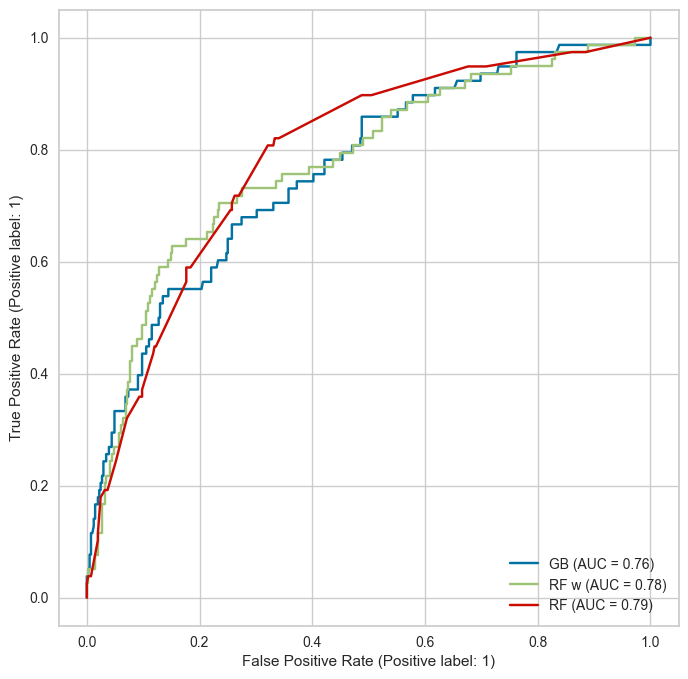

In [66]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(gb_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='GB');
RocCurveDisplay.from_estimator(rf_cw_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='RF w');
RocCurveDisplay.from_estimator(rf_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="RF");

In [67]:
results_df.sort_values(by=['test acc', 'ROC AUC'], ascending=False)

,test acc,test f1 score (0),test f1 score (1),test f1 score (W),ROC AUC
Gradient Boosting,0.850,0.914,0.416,0.665,0.765
DTree base,0.848,0.915,0.302,0.608,0.710
Random Forest,0.840,0.911,0.170,0.541,0.789
Random Forest CW,0.840,0.910,0.250,0.580,0.777
Extra Trees CW,0.840,0.910,0.250,0.580,0.777
DTree under samp,0.837,0.907,0.358,0.632,0.700
DTree SMOTE,0.827,0.905,0.087,0.496,0.681
DTree over samp,0.823,0.899,0.306,0.603,0.677
DTree class weights,0.772,0.861,0.351,0.606,0.640


Aqui podemos observar todos los modelos que hemos ido generando. Si nos fijamos en la AUC y el acierto, dependiendo de la aleatoriedad tendremos resultados más o menos parecidos, aunque en alguna ocasión alguno de ellos puede diferenciarse.


Habría que ver si la diferencia es significativa, eso involucraría hacer una validación cruzada anidada, en la que dejaramos fuera diferentes muestras de test para poder tener una distribución de valores y usar un test estadístico sobre la media de los resultados

### Ensembles generales

Obviamente no solo podemos combinar árboles de decisión, podemos combinar varios modelos que nos den visiones diferentes del problema y ver si eso mejora el resultado. Claramente no tenemos ninguna garantia de que eso sea así, es posible que todos los modelos que usemos acaben convergiendo a una frontera de decisión similar y que la combinación no nos ayude

Empezaremos por añadir dos clasificadores diferentes que podamos combinar con los de árboles de decisión, Regresión logística y Naive Bayes Gausiano. Este último no encaja perfectamente ya que tenemos atributos nominales, pero eso podría ayudar a obtener diversidad en los clasificadores.

Empezaremos por regresión logística

In [68]:
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,101, endpoint=True)}
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr_bs =  BayesSearchCV(lr,param,n_iter=iter,cv=cv, n_jobs=-1, refit=True, random_state=0)
lr_bs.fit(X_train, y_train);

In [69]:
show_html(pd.DataFrame(lr_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
24,"{'C': 47.863009232263806, 'penalty': 'l1'}",0.868,1
22,"{'C': 288.40315031266056, 'penalty': 'l1'}",0.868,1
31,"{'C': 1.1481536214968828, 'penalty': 'l1'}",0.867,3
39,"{'C': 1.7378008287493745, 'penalty': 'l1'}",0.867,4
5,"{'C': 109.64781961431851, 'penalty': 'l2'}",0.867,4


Sorprendentemente el resultado es mejor que el de todos los modelos que hemos probado hasta ahora. Esto nos debería hacer pensar que cuando abordamos un problema tiene sentido el empezar por modelos más sencillos que nos permitan ver cuál es el mínimo modelo que podemos obtener y a partir de el ver si modelos más complejos merecen la pena. En este caso tenemos un modelo que solo necesita un numero lineal de pesos que ocupa bastante menos que los ensembles.

In [70]:
print(classification_report(lr_bs.predict(X_test), y_test,target_names=cls))
results_df = save_results(lr_bs, X_test, y_test, 'Logistic Regression', results_df)

              precision    recall  f1-score   support

          No       0.98      0.87      0.92       455
         Yes       0.27      0.68      0.39        31

    accuracy                           0.86       486
   macro avg       0.62      0.78      0.65       486
weighted avg       0.93      0.86      0.89       486



Podemos ver la mejora en el número de vp respecto al de fp.

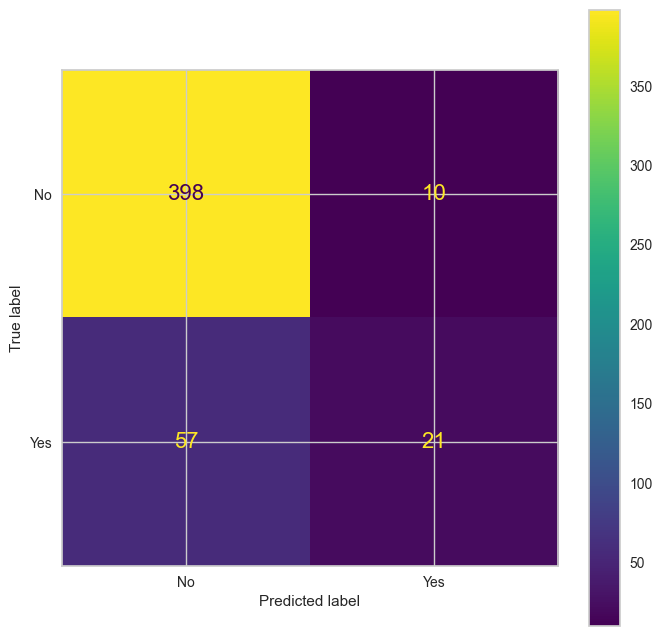

In [71]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_bs, X_test,y_test, display_labels=cls, ax=plt.subplot());

La curva ROC es ligeramente mejor, también podemos llegar a mas de 70% de vp sin llegar al 20% del fp.

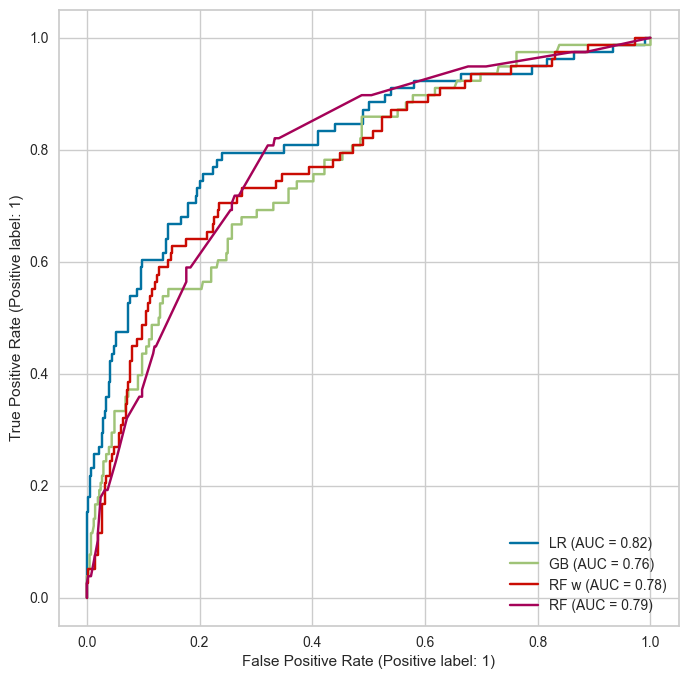

In [72]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(lr_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='LR');
RocCurveDisplay.from_estimator(gb_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='GB');
RocCurveDisplay.from_estimator(rf_cw_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='RF w');
RocCurveDisplay.from_estimator(rf_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="RF");

Vamos a probar ahora con Naïve Bayes, en este modelo no hay ningún parámetro que ajustar y como hemos comentado los datos no cumplen exactamente lo que asume el modelo.

In [73]:
gnb = GaussianNB()
print(np.mean(cross_val_score(gnb,X_train,y_train,cv=cv)))   
gnb.fit(X_train, y_train);

0.776499690785405


No podíamos esperar que este modelo fuera mejor, pero sorprendentemente (o no tanto) obtiene un buen resultado en la clase positiva, eso nos dice que al menos este clasificador tiene una visión diferente de los datos. Su acierto global es peor que el del resto de modelos.

In [74]:
print(classification_report(gnb.predict(X_test), y_test,target_names=cls))
results_df = save_results(gnb, X_test, y_test, 'Naive Bayes', results_df)

              precision    recall  f1-score   support

          No       0.82      0.92      0.87       363
         Yes       0.63      0.40      0.49       123

    accuracy                           0.79       486
   macro avg       0.72      0.66      0.68       486
weighted avg       0.77      0.79      0.77       486



Podemos ver que hay bastantes ejemplos de la clase positiva bien clasificados y con un mejor ratio con los falsos positivos que muchos de los modelos de árboles. 

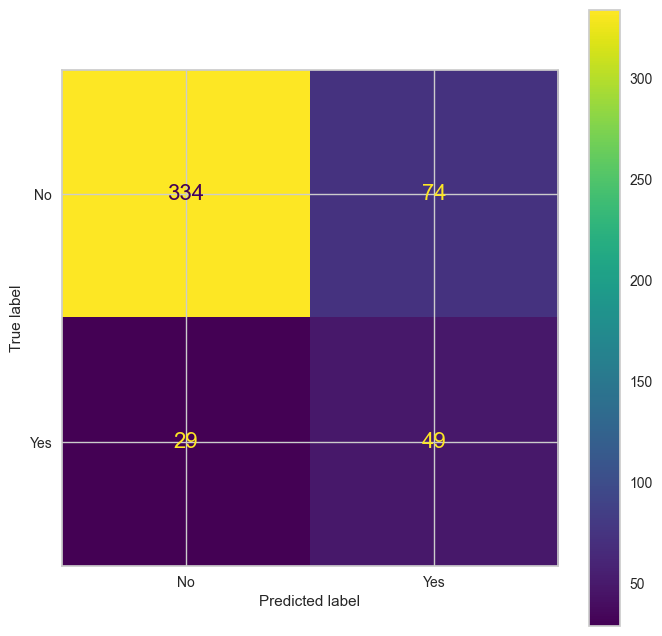

In [75]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb, X_test,y_test, display_labels=cls, ax=plt.subplot());

En la curva ROC podemos ver que obtener cerca de un 70% de vp da un ratio de fp de alrededor del 20% que es mejor que muchos de los modelos de árboles y el AUC es similar.

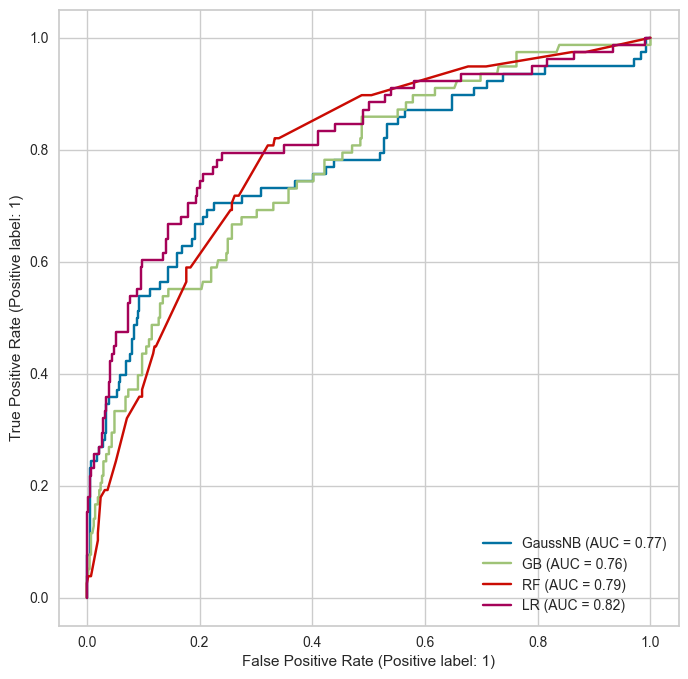

In [76]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(gnb, X_test,y_test, pos_label=1, ax=plt.subplot(), name='GaussNB');
RocCurveDisplay.from_estimator(gb_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='GB');
RocCurveDisplay.from_estimator(rf_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="RF");
RocCurveDisplay.from_estimator(lr_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='LR');

In [77]:
results_df.sort_values(by=['test acc', 'ROC AUC'], ascending=False)

,test acc,test f1 score (0),test f1 score (1),test f1 score (W),ROC AUC
Logistic Regression,0.862,0.922,0.385,0.654,0.820
Gradient Boosting,0.850,0.914,0.416,0.665,0.765
DTree base,0.848,0.915,0.302,0.608,0.710
Random Forest,0.840,0.911,0.170,0.541,0.789
Random Forest CW,0.840,0.910,0.250,0.580,0.777
Extra Trees CW,0.840,0.910,0.250,0.580,0.777
DTree under samp,0.837,0.907,0.358,0.632,0.700
DTree SMOTE,0.827,0.905,0.087,0.496,0.681
DTree over samp,0.823,0.899,0.306,0.603,0.677
Naive Bayes,0.788,0.866,0.488,0.677,0.772


## Voting

Empezaremos haciendo un clasificador que corresponda la votación entre varios clasificadores

El primero consistira en gradient boosting (podemos elegir el que mejor resultado nos de según el resultado que nos de la ejecución, pero puede no haber una gran diferencia) con regresión logística, usaremos votacion soft para poder usar las probabilidades de la clasificacion.

In [78]:
vs1 = VotingClassifier([('gb', gb_bs.best_estimator_),
                        ('lr', lr_bs.best_estimator_)],voting='soft', n_jobs=1)
print(np.mean(cross_val_score(vs1,X_train,y_train,cv=cv)))                             
vs1.fit(X_train, y_train);                          

0.8821170892599464


Podemos ver hemos conseguido mejorar algo tanto en la clasificacion global como en el f1 de la clase positiva

In [79]:
print(classification_report(vs1.predict(X_test), y_test,target_names=cls))
results_df = save_results(vs1, X_test, y_test, 'Voting GB+LR', results_df)

              precision    recall  f1-score   support

          No       0.98      0.89      0.93       449
         Yes       0.36      0.76      0.49        37

    accuracy                           0.88       486
   macro avg       0.67      0.82      0.71       486
weighted avg       0.93      0.88      0.90       486



Eso se puede ver en los conteos de la matriz de confusión hemos disminuido ligeramente los fp y aumentado los vp

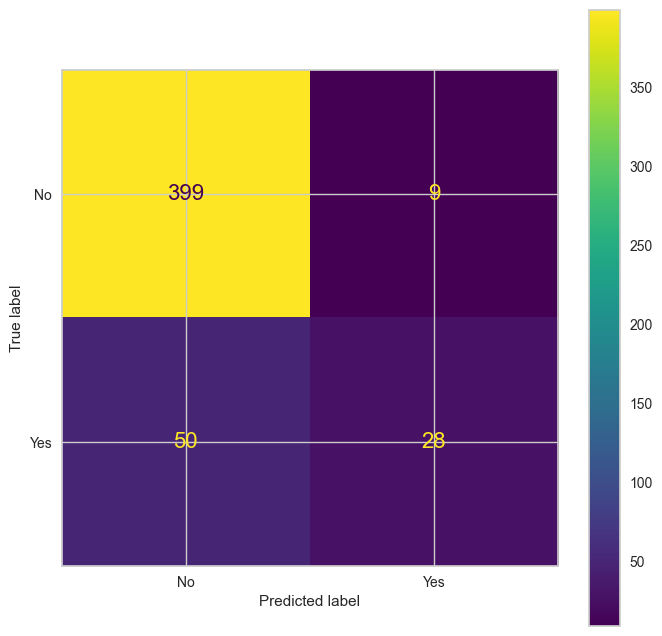

In [80]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(vs1, X_test,y_test, display_labels=cls, ax=plt.subplot());

La curva ROC es parecida a la de LR habría que ver exactamente el ratio vp/fp en los puntos de corte, pero podemos ver que la AUC ha aumentado ligeramente, asi que este modelo es mejor que los que hemos obtenido hasta ahora.

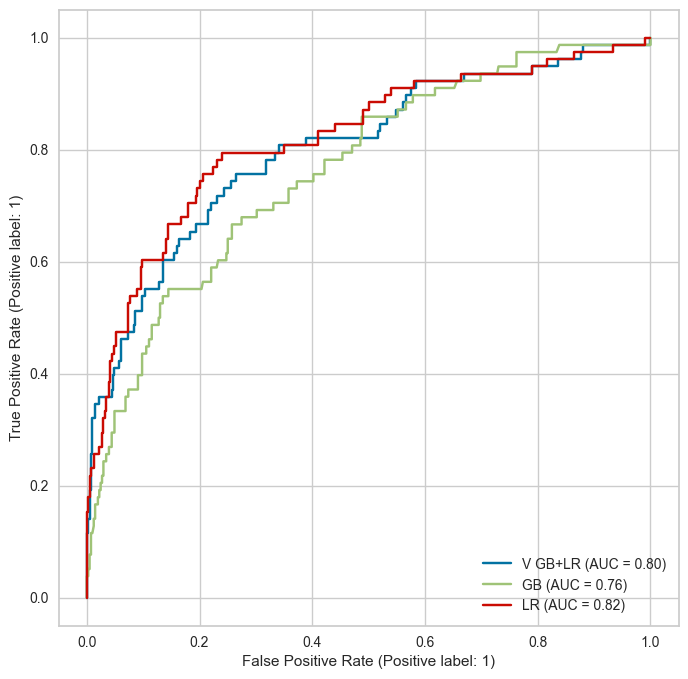

In [81]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(vs1, X_test,y_test, pos_label=1, ax=plt.subplot(), name='V GB+LR');
RocCurveDisplay.from_estimator(gb_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='GB');
RocCurveDisplay.from_estimator(lr_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='LR');

Podemos ver que pasa si le añadimos Naive Bayes (para poder romper posibles empates si el que los hubiera) y además aprovechar que las decisiones de este modelo son diferentes y más sesgadas a la clase minoritaria

In [82]:
vs2 = VotingClassifier([('gb', gb_bs.best_estimator_),
                        ('nb', gnb),   
                        ('lr', lr_bs.best_estimator_)],voting='soft', n_jobs=1)
print(np.mean(cross_val_score(vs2,X_train,y_train,cv=cv)))                             
vs2.fit(X_train, y_train);                          

0.8780560709132137


Vemos que el resultado varia sesgandolo hacia la clase positiva, el resultado global de acierto es prácticamente el mismo, pero tiene el f1 para la clase positiva mejor de todos los que hemos obtenido

In [83]:
print(classification_report(vs2.predict(X_test), y_test,target_names=cls))
results_df = save_results(vs2, X_test, y_test, 'Voting GB+GNB+LR', results_df)

              precision    recall  f1-score   support

          No       0.94      0.89      0.91       434
         Yes       0.37      0.56      0.45        52

    accuracy                           0.85       486
   macro avg       0.66      0.72      0.68       486
weighted avg       0.88      0.85      0.86       486



Eso se puede ver en la matriz de confusión, hemos perdido algunos de la clase negativa y los hemos ganado en la positiva

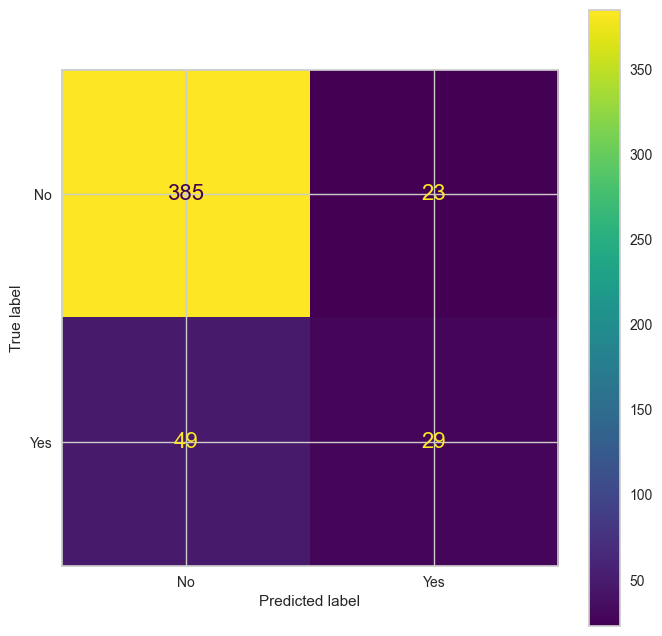

In [84]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(vs2, X_test,y_test, display_labels=cls, ax=plt.subplot());

Aqui también deberíamos examinar los puntos de corte, la AUC es muy parecida a la de LR, las curvas son mejores en diferentes partes del limite de decision

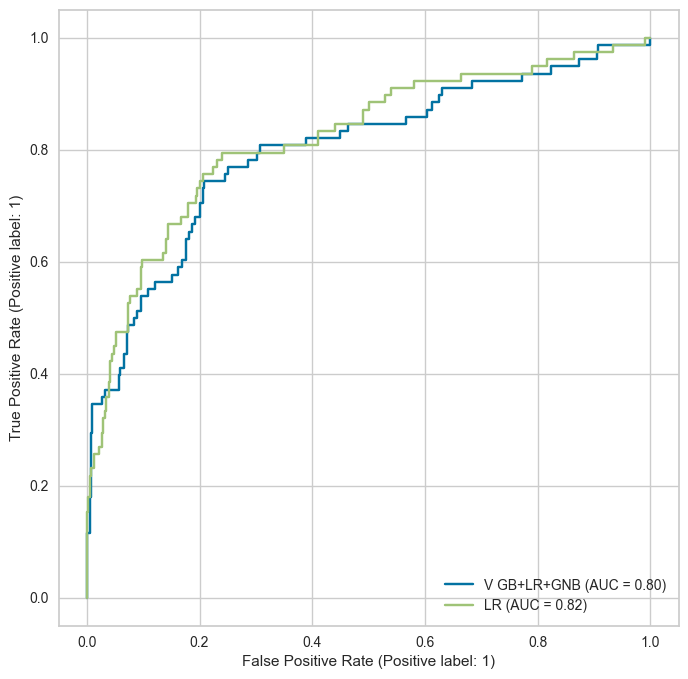

In [85]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(vs2, X_test,y_test, pos_label=1, ax=plt.subplot(), name='V GB+LR+GNB');
RocCurveDisplay.from_estimator(lr_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='LR');

Superponiendo los dos ensembles podemos ver que la curva del primer modelo es superior prácticamente en todo su recorrido, el corte del mas o menos 70%/20% que hemos ido observando es prácticamente idéntico, asi que el primer modelo sería un poco mejor.

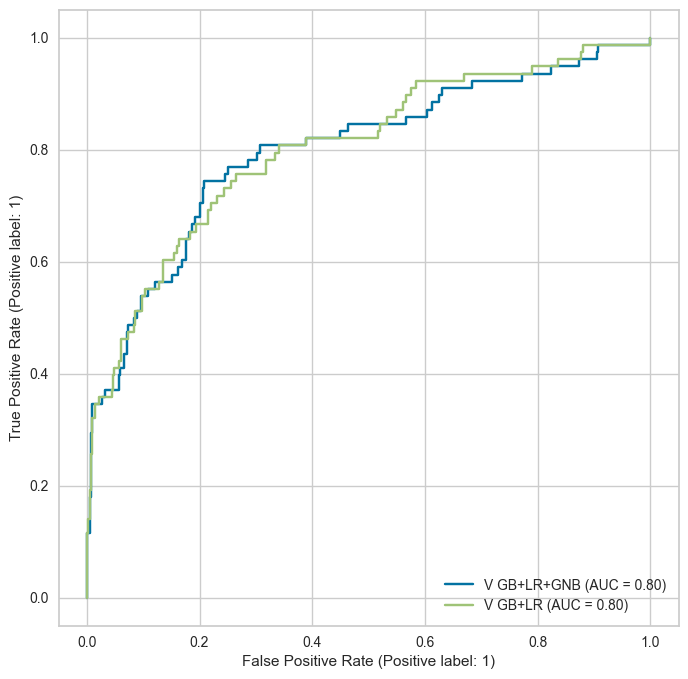

In [86]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(vs2, X_test,y_test, pos_label=1, ax=plt.subplot(), name='V GB+LR+GNB');
RocCurveDisplay.from_estimator(vs1, X_test,y_test, pos_label=1, ax=plt.subplot(), name='V GB+LR');

# Stacking

Finalmente podemos probar stacking, en este caso aprendemos a como combinar las decisiones de los clasificadores, sobre los resulados ponemos una regresión logística (el modelo por defecto) en lugar de simplemente hacer la media de las probabilidades.

In [87]:
st1 = StackingClassifier([('gb', gb_bs.best_estimator_),
                          ('lr', lr_bs.best_estimator_)],
                          cv=cv, n_jobs=1)
print(np.mean(cross_val_score(st1,X_train,y_train,cv=cv)))                             
st1.fit(X_train, y_train);                          

0.8871882086167799


No hay mucha diferencia, hemos ganado algo de acierto.

In [88]:
print(classification_report(st1.predict(X_test), y_test,target_names=cls))
results_df = save_results(st1, X_test, y_test, 'Stacking GB+LR', results_df)

              precision    recall  f1-score   support

          No       0.97      0.89      0.92       444
         Yes       0.36      0.67      0.47        42

    accuracy                           0.87       486
   macro avg       0.66      0.78      0.70       486
weighted avg       0.91      0.87      0.89       486



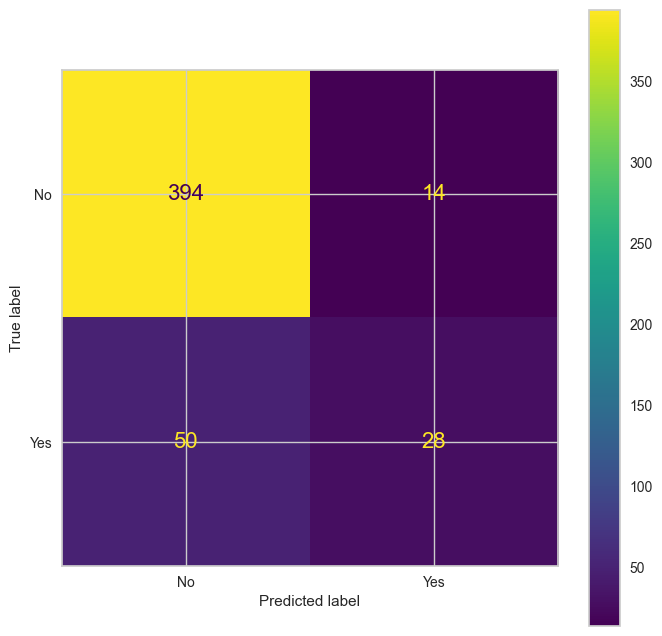

In [89]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(st1, X_test,y_test, display_labels=cls, ax=plt.subplot());

Si superponemos las dos curvas ROC vemos que son prácticamente idénticas

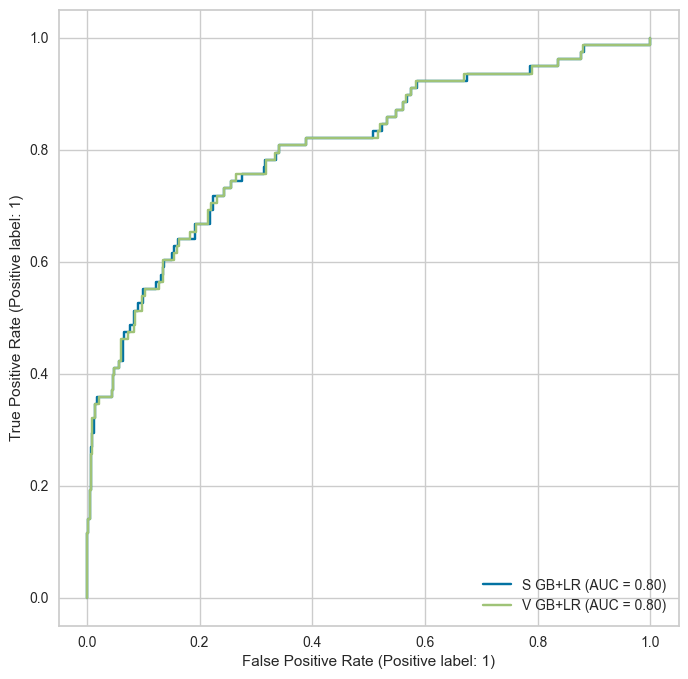

In [90]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(st1, X_test,y_test, pos_label=1, ax=plt.subplot(), name='S GB+LR');
RocCurveDisplay.from_estimator(vs1, X_test,y_test, pos_label=1, ax=plt.subplot(), name='V GB+LR');

Este modelo final está a un nivel parecido al voting, como comentamos antes habría que hacer validación cruzada anidada para obtener una distribución y comprobar si realmente hay una diferencia estadística entre modelos.

A falta de ella, podemos decidirnos por el modelos con mejores valores en todos los criterios.

Si queremos un modelo sencillo ligeramente peor nos podemos dedicidir por la regresión logística

Si queremos un modelo que esté ligeramenente sesgado hacia la clase positiva el modelo de votación que combina los tres mejores clasificadores sería nuestra opción.

In [91]:
results_df.sort_values(by=['test acc', 'ROC AUC'], ascending=False)

,test acc,test f1 score (0),test f1 score (1),test f1 score (W),ROC AUC
Voting GB+LR,0.879,0.931,0.487,0.709,0.803
Stacking GB+LR,0.868,0.925,0.467,0.696,0.803
Logistic Regression,0.862,0.922,0.385,0.654,0.820
Voting GB+GNB+LR,0.852,0.914,0.446,0.680,0.799
Gradient Boosting,0.850,0.914,0.416,0.665,0.765
DTree base,0.848,0.915,0.302,0.608,0.710
Random Forest,0.840,0.911,0.170,0.541,0.789
Random Forest CW,0.840,0.910,0.250,0.580,0.777
Extra Trees CW,0.840,0.910,0.250,0.580,0.777
DTree under samp,0.837,0.907,0.358,0.632,0.700


In [92]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:07:06.518080
